In [1]:
import warnings
from itertools import product
from time import time
from typing import Any

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
from numpy.random import normal, seed
from theano import tensor as tt

from speclet.data_processing.common import make_cat
from speclet.string_functions import prefixed_count

# Remove annoying filters from some dated ArViz functions.
warnings.simplefilter(action="ignore", category=UserWarning)

# Default theme for Plotnine.
gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

# A value to use in all random seed setting instances.
RANDOM_SEED = 103

notebook_tic = time()

---

## Model 7. Generation using varying sgRNA|gene and cell line effects

Model the effects of knocking out gene $g$ with sgRNA $s$ in cell line $c$.
The data will be generated with the following model, but then different models structures will be tested.

$
logFC_{s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_s + \beta_c \\
\quad \alpha_s \sim \mathcal{N}(\mu_{\alpha_s}, \sigma_\alpha) \\
\qquad \mu_{\alpha_s} = \gamma_g \\
\qquad\quad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 10
- number of repeated measures: $[1 , 2 , \dots , 10]$
- $\mu_\gamma = -1.0$, $\sigma_\gamma = 0.5$
- $\sigma_\alpha = 0.2$
- $\mu_\beta = 0$, $\sigma_\beta = 1$
- $\sigma = 0.3$

In [2]:
seed(RANDOM_SEED)

num_cell_lines = 20
num_genes = 10
num_sgrna_per_gene = list(range(1, num_genes + 1))
num_sgrnas = sum(num_sgrna_per_gene)

cell_lines = prefixed_count("cell_", num_cell_lines)
genes = prefixed_count("gene_", num_genes)
sgrnas = prefixed_count("sgRNA_", num_sgrnas)

# RP ("real parameters")
RP: dict[str, Any] = {
    "mu_gamma": -1.0,
    "sigma_gamma": 0.5,
    "sigma_alpha": 0.2,
    "mu_beta": 0.0,
    "sigma_beta": 1.0,
    "sigma": 0.3,
}

RP["gamma_g"] = normal(loc=RP["mu_gamma"], scale=RP["sigma_gamma"], size=num_genes)
RP["beta_c"] = normal(loc=RP["mu_beta"], scale=RP["sigma_beta"], size=num_cell_lines)

sgrna_df = pd.DataFrame({"gene": np.repeat(genes, num_sgrna_per_gene), "sgRNA": sgrnas})
for col in sgrna_df.columns:
    sgrna_df = make_cat(sgrna_df, col)

alpha_s = []
for gene_i in sgrna_df["gene"].cat.codes:
    alpha_s.append(normal(loc=RP["gamma_g"][gene_i], scale=RP["sigma_alpha"]))


RP["alpha_s"] = alpha_s

data = pd.DataFrame(product(cell_lines, sgrnas), columns=["cell_line", "sgRNA"])
data = data.merge(sgrna_df, on="sgRNA")


for col in data.columns:
    data = make_cat(data, col)


for i in range(len(data)):
    cell_i = data["cell_line"].cat.codes[i]
    sgrna_i = data["sgRNA"].cat.codes[i]
    mu_sc = RP["alpha_s"][sgrna_i] + RP["beta_c"][cell_i]
    data.loc[i, "mu_sc"] = mu_sc
    data.loc[i, "log_fc"] = normal(loc=mu_sc, scale=RP["sigma"])

data

cell_line       sgRNA      gene     mu_sc    log_fc
0      cell_0.0   sgRNA_0.0  gene_0.0 -1.284686 -0.974021
1      cell_1.0   sgRNA_0.0  gene_0.0 -1.986886 -2.358464
2      cell_2.0   sgRNA_0.0  gene_0.0 -0.883180 -0.911884
3      cell_3.0   sgRNA_0.0  gene_0.0 -0.267206 -0.774813
4      cell_4.0   sgRNA_0.0  gene_0.0 -3.064072 -2.866197
...         ...         ...       ...       ...       ...
1095  cell_15.0  sgRNA_54.0  gene_9.0 -2.116856 -2.188318
1096  cell_16.0  sgRNA_54.0  gene_9.0 -2.245777 -1.630069
1097  cell_17.0  sgRNA_54.0  gene_9.0 -1.079010 -0.752161
1098  cell_18.0  sgRNA_54.0  gene_9.0 -1.900383 -1.697479
1099  cell_19.0  sgRNA_54.0  gene_9.0 -1.452215 -1.609552

[1100 rows x 5 columns]

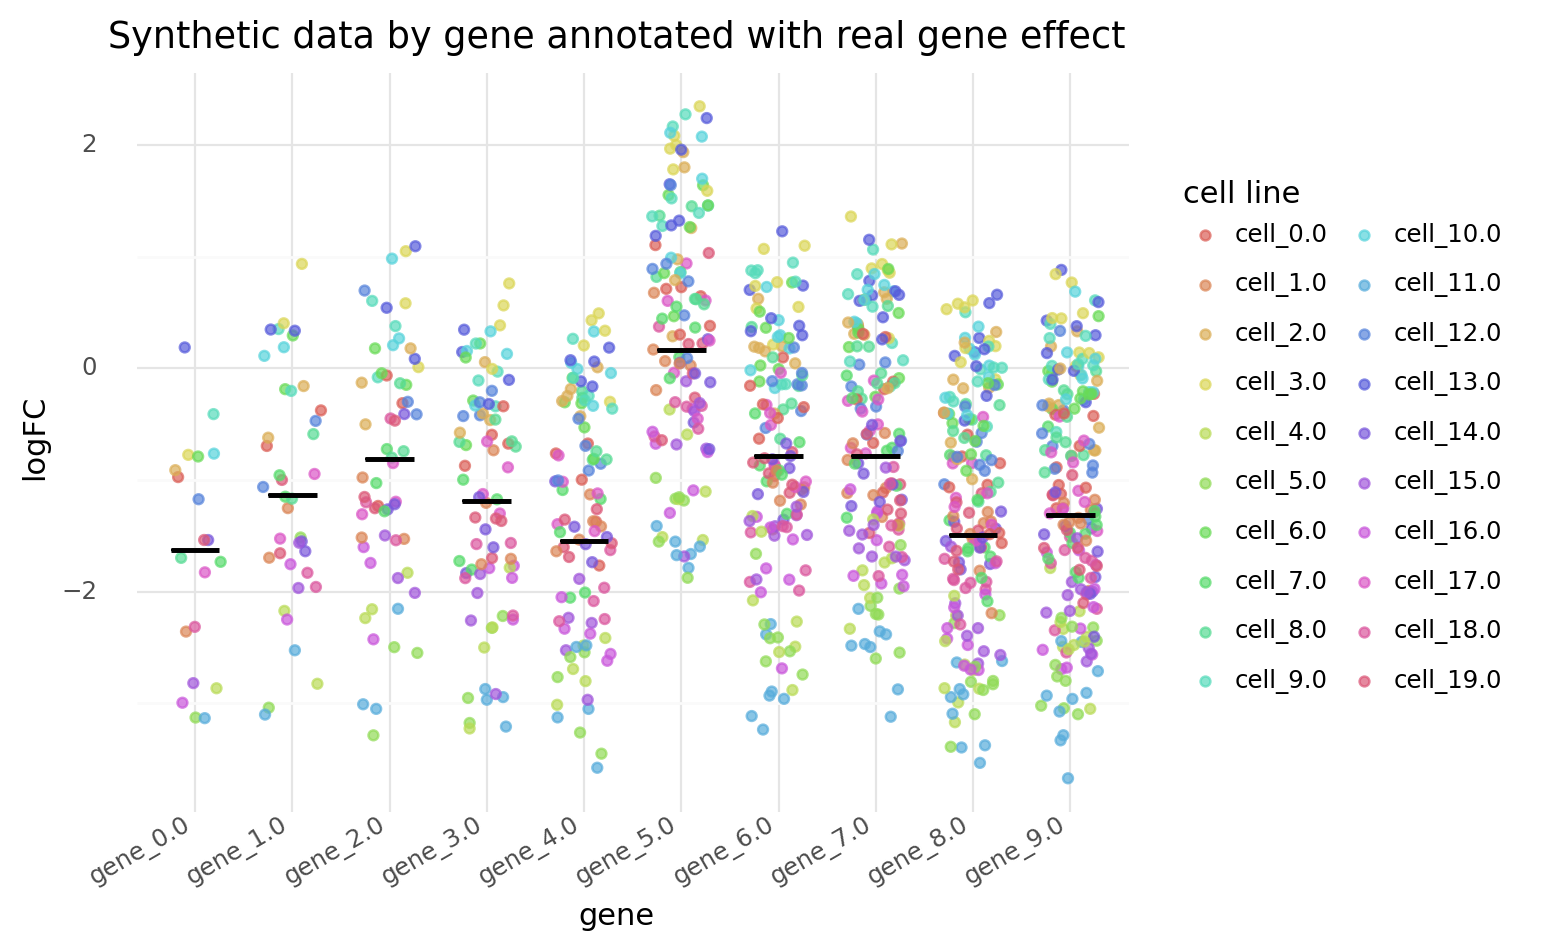

<ggplot: (8741441743373)>

In [3]:
real_gene_vals = pd.DataFrame({"gene": genes, "log_fc": RP["gamma_g"]})

(
    gg.ggplot(data, gg.aes(x="gene", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.7)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_gene_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, vjust=0.2))
    + gg.labs(
        x="gene",
        y="logFC",
        title="Synthetic data by gene annotated with real gene effect",
    )
)

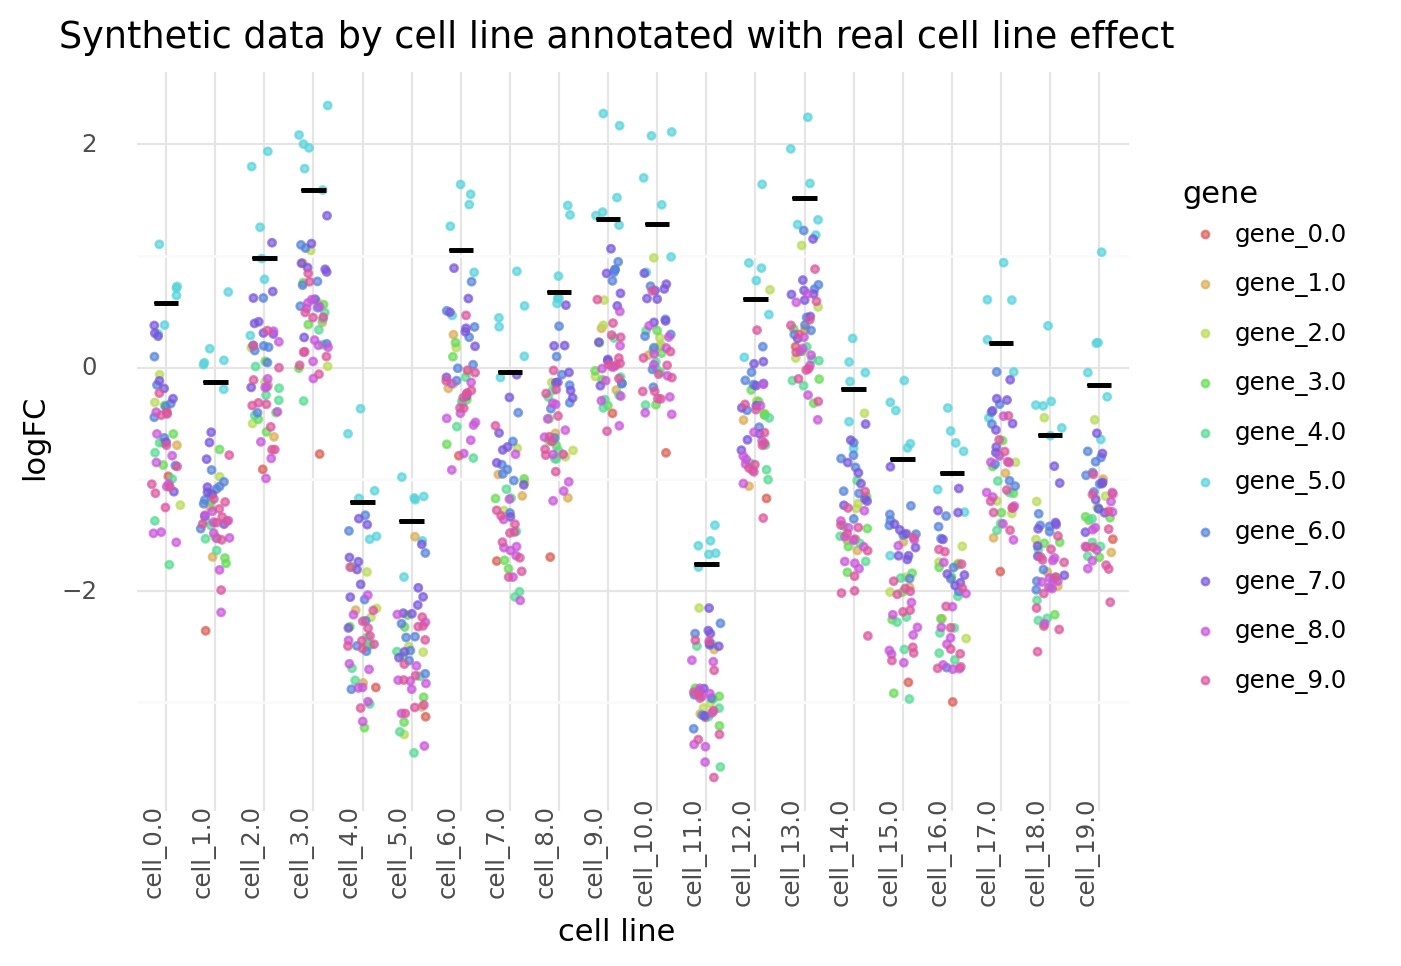

<ggplot: (8741431597698)>

In [4]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="cell_line", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="gene"), height=0, width=0.3, alpha=0.7, size=1)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_cellline_vals)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="gene", ncol=1))
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=1, vjust=0.5))
    + gg.labs(
        x="cell line",
        y="logFC",
        title="Synthetic data by cell line annotated with real cell line effect",
    )
)

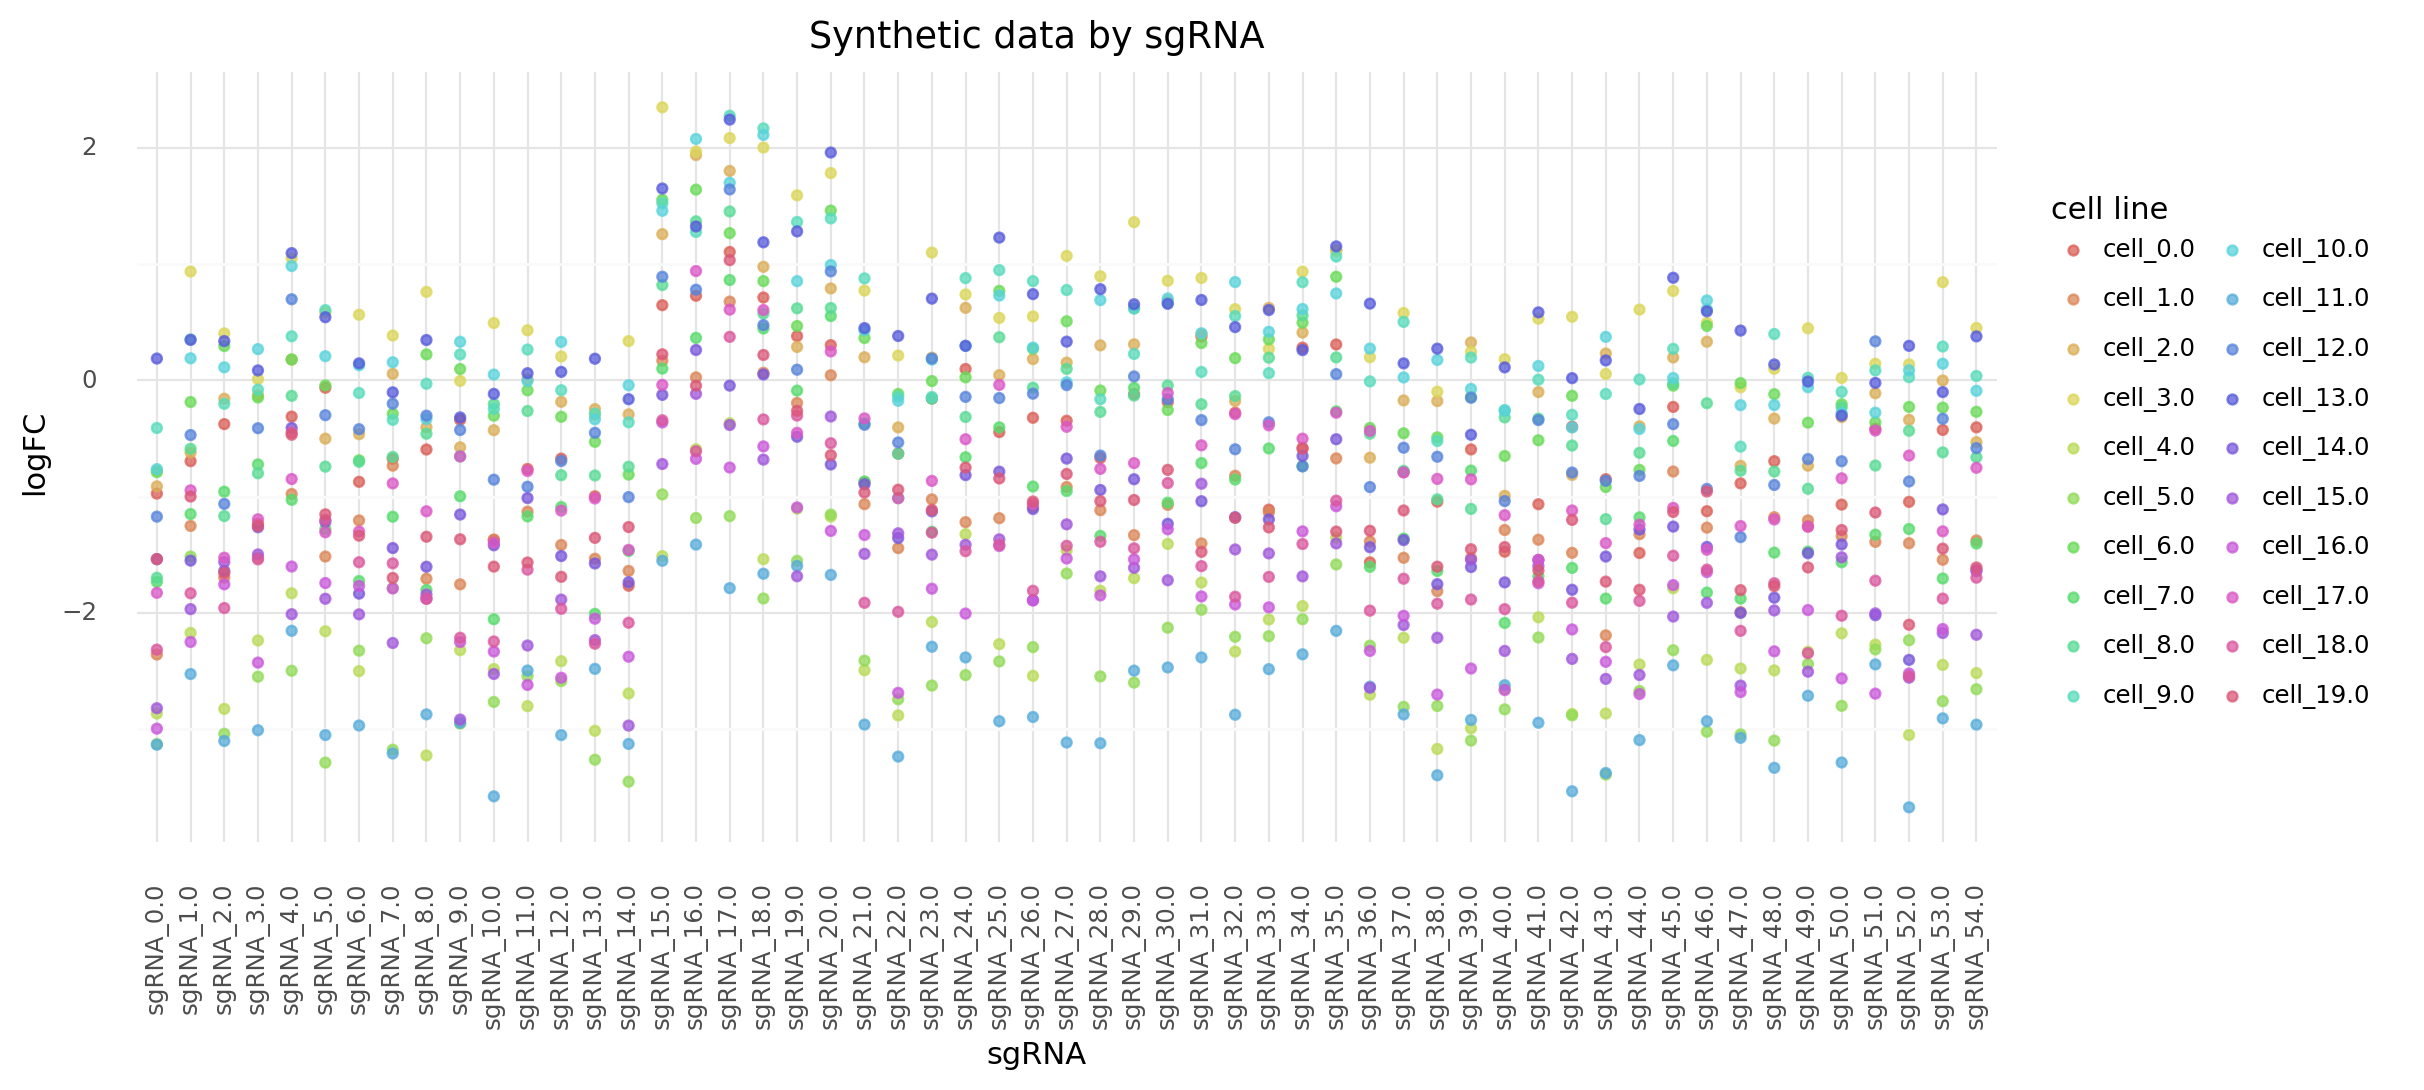

<ggplot: (8741432659755)>

In [5]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})

(
    gg.ggplot(data, gg.aes(x="sgRNA", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0, alpha=0.75)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1), figure_size=(12, 5)
    )
    + gg.labs(
        x="sgRNA",
        y="logFC",
        title="Synthetic data by sgRNA",
    )
)

## Model 7a. A 2-Dimensional varying intercept.

A model with just a varying intercept in the main level.
The varying intercept is 2-dimensional: one dimension for gene and one for the cell line.
This varying intercept has a 1D prior.

$
logFC_{i,g,c} \sim \mathcal{N}(\mu_{g,c}, \sigma) \\
\mu_{g,c} = \alpha_{g,c} \\
\quad \alpha_{g,c} \sim \mathcal{N}(\mu_{\alpha_{g,c}}, \sigma_\alpha) \\
\qquad \mu_{\alpha_{g,c}} \sim \mathcal{N}(0,5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [6]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7a:
    # Hyper-priors
    mu_alpha_gc = pm.Normal("mu_alpha_gc", 0, 5)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    # Linear model parameters
    alpha_gc = pm.Normal(
        "alpha_gc", mu_alpha_gc, sigma_alpha, shape=(num_genes, num_cell_lines)
    )

    # Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_gc[gene_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7a_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7a_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7a_post_check = pm.sample_posterior_predictive(m7a_trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_gc, sigma_alpha, mu_alpha_gc]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


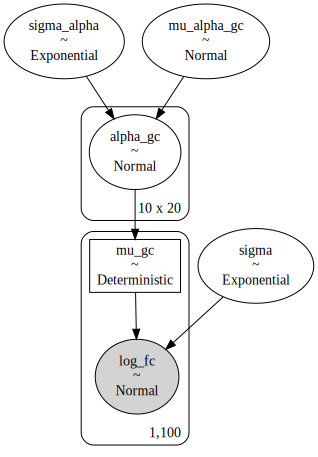

In [7]:
pm.model_to_graphviz(m7a)

In [8]:
az_m7a = az.from_pymc3(
    trace=m7a_trace,
    model=m7a,
    posterior_predictive=m7a_post_check,
    prior=m7a_prior_check,
)

In [9]:
m7a_post = (
    az.summary(az_m7a, var_names=["alpha_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7a_post.head(n=10)

intercept   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
0  alpha_gc[0,0] -0.972  0.327  -1.561   -0.362      0.003    0.002   14043.0   
1  alpha_gc[0,1] -2.230  0.329  -2.864   -1.631      0.003    0.002   14008.0   
2  alpha_gc[0,2] -0.912  0.331  -1.516   -0.274      0.003    0.002   12070.0   
3  alpha_gc[0,3] -0.789  0.335  -1.406   -0.152      0.003    0.002   13450.0   
4  alpha_gc[0,4] -2.692  0.335  -3.307   -2.054      0.003    0.002   14792.0   
5  alpha_gc[0,5] -2.934  0.335  -3.578   -2.310      0.003    0.002   12694.0   
6  alpha_gc[0,6] -0.800  0.335  -1.405   -0.148      0.003    0.002   16092.0   
7  alpha_gc[0,7] -1.661  0.334  -2.290   -1.041      0.003    0.002   13435.0   
8  alpha_gc[0,8] -1.630  0.337  -2.245   -0.978      0.003    0.002   12626.0   
9  alpha_gc[0,9] -0.460  0.332  -1.089    0.164      0.003    0.003   15090.0   

    ess_sd  ess_bulk  ess_tail  r_hat  gene_idx  cell_line_idx      gene  \
0  11904.0   14082.0    6079.0    1.0         0              0  gene_0.0   
1  13747.0   14010.0    5482.0    1.0         0              1  gene_0.0   
2  10600.0   12058.0    5677.0    1.0         0              2  gene_0.0   
3  10194.0   13453.0    5940.0    1.0         0              3  gene_0.0   
4  14280.0   14820.0    5968.0    1.0         0              4  gene_0.0   
5  12551.0   12683.0    6005.0    1.0         0              5  gene_0.0   
6  11237.0   16109.0    6175.0    1.0         0              6  gene_0.0   
7  12682.0   13434.0    5346.0    1.0         0              7  gene_0.0   
8  11765.0   12662.0    5187.0    1.0         0              8  gene_0.0   
9   7381.0   15109.0    5020.0    1.0         0              9  gene_0.0   

  cell_line  
0  cell_0.0  
1  cell_1.0  
2  cell_2.0  
3  cell_3.0  
4  cell_4.0  
5  cell_5.0  
6  cell_6.0  
7  cell_7.0  
8  cell_8.0  
9  cell_9.0

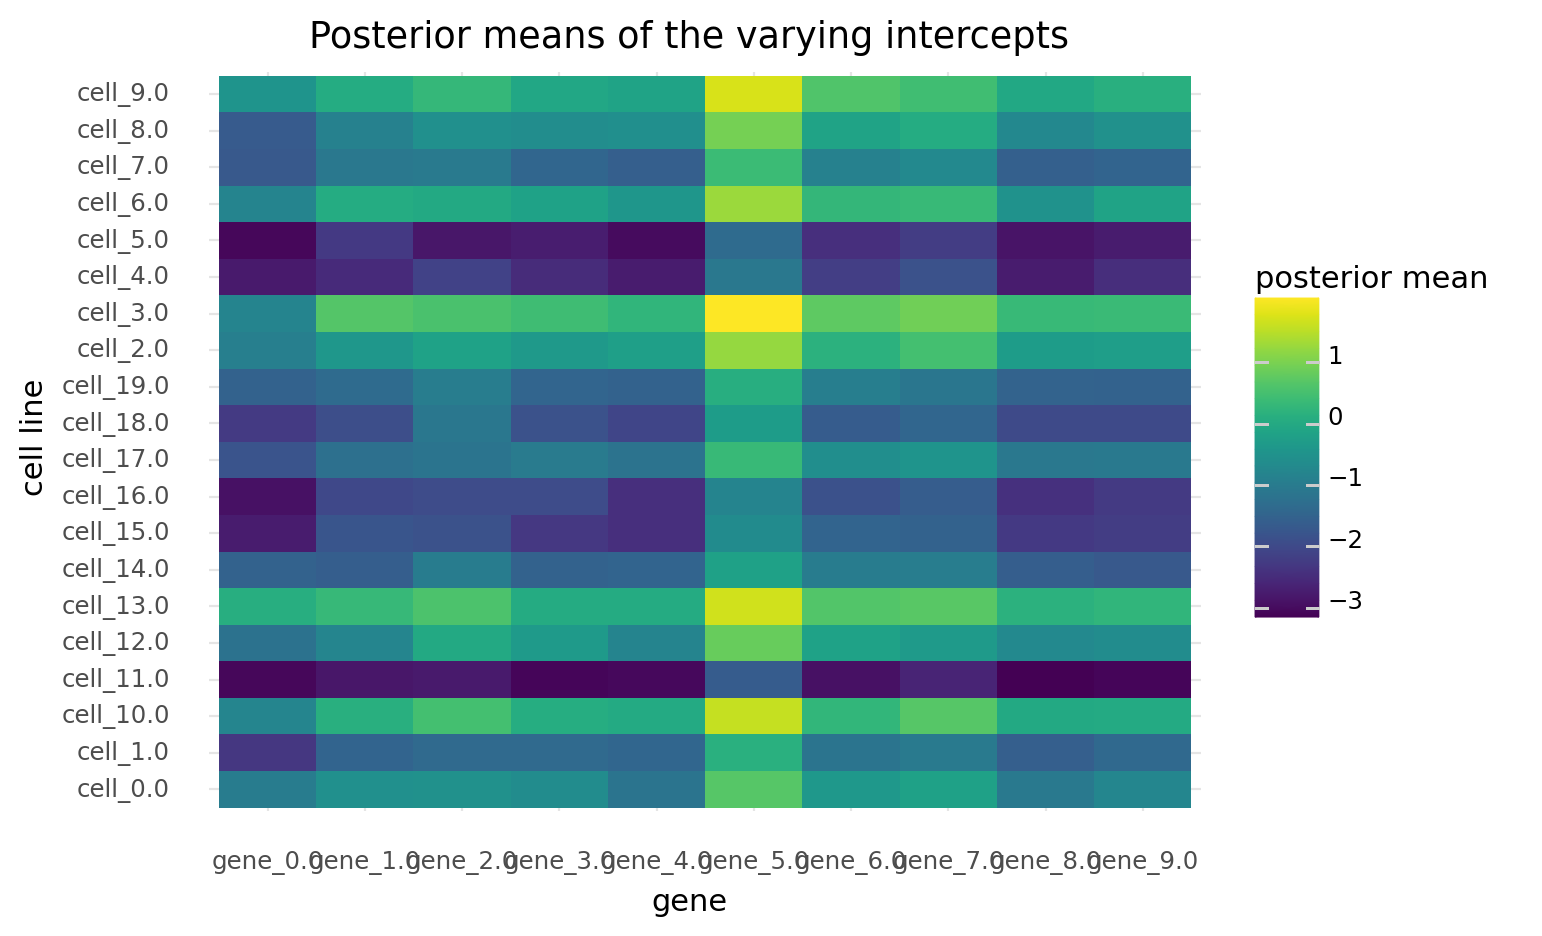

<ggplot: (8741414487209)>

In [10]:
(
    gg.ggplot(m7a_post, gg.aes(x="gene", y="cell_line"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.labs(
        x="gene",
        y="cell line",
        fill="posterior mean",
        title="Posterior means of the varying intercepts",
    )
)

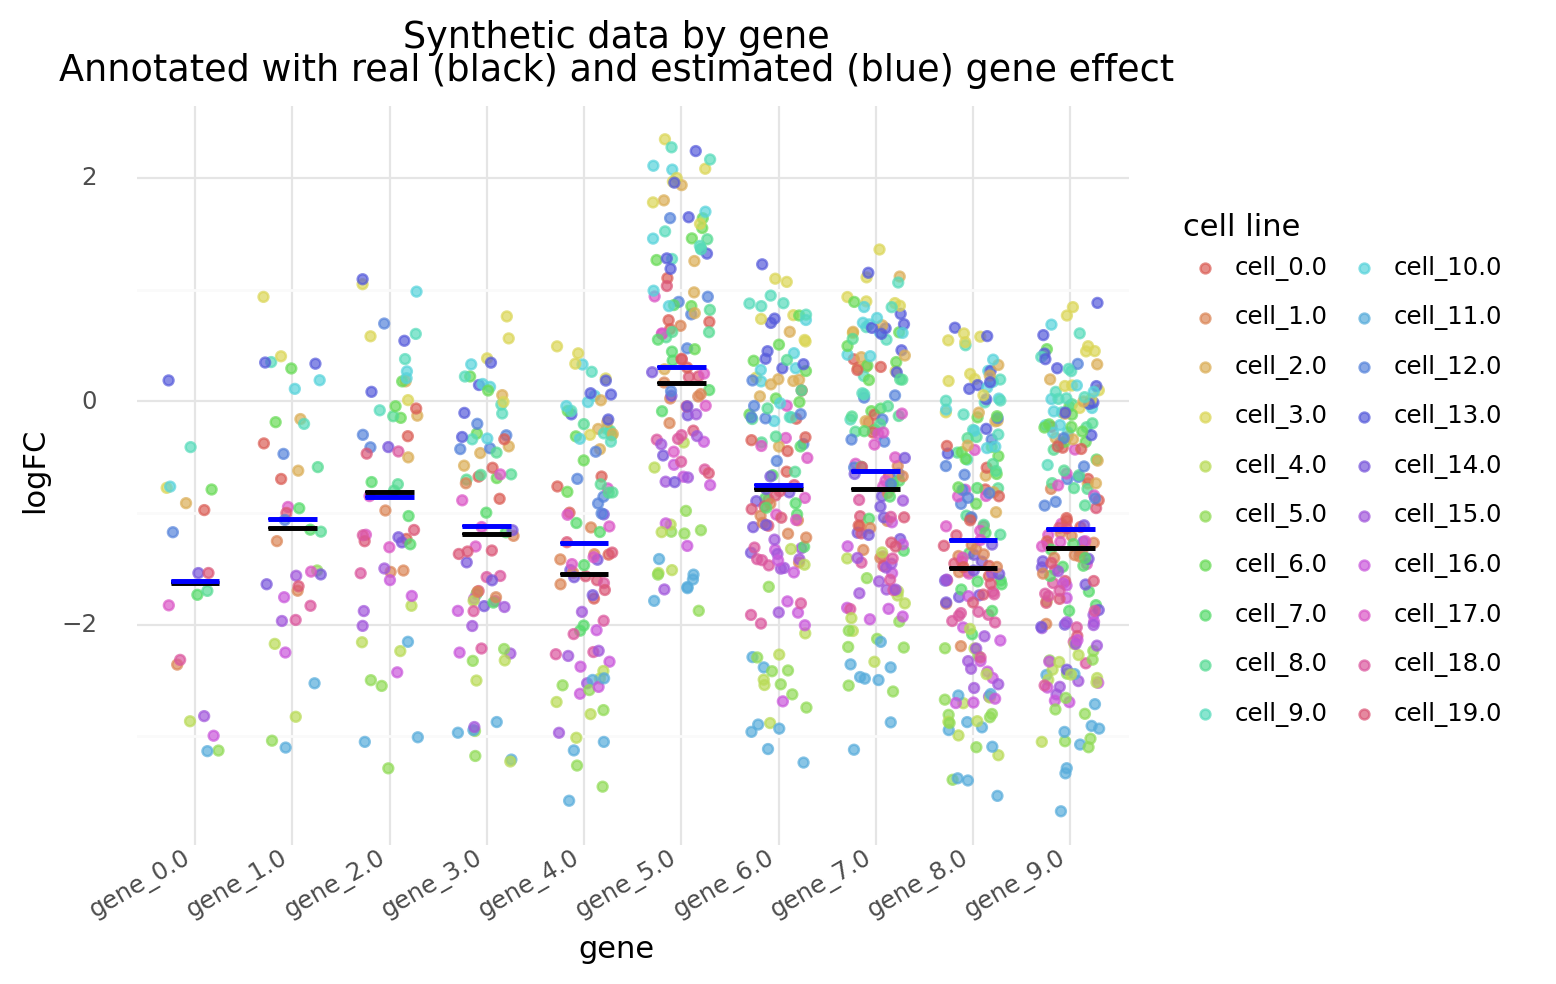

<ggplot: (8741396097988)>

In [11]:
real_gene_vals = pd.DataFrame({"gene": genes, "log_fc": RP["gamma_g"]})
gene_posteriors = m7a_post[["gene", "mean"]].groupby("gene").mean().reset_index()

(
    gg.ggplot(data, gg.aes(x="gene", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.7)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_gene_vals)
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"), data=gene_posteriors, color="blue"
    )
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.theme(axis_text_x=gg.element_text(angle=30, hjust=1, vjust=0.2))
    + gg.labs(
        x="gene",
        y="logFC",
        title="Synthetic data by gene\nAnnotated with real (black) and estimated (blue) gene effect",
    )
)

The cell line effect is exaggerated and the gene effect is well estimated. 
This is probably because most of the effect is comming from the genes, but the varying intercept only has one value per gene-cell line pair.

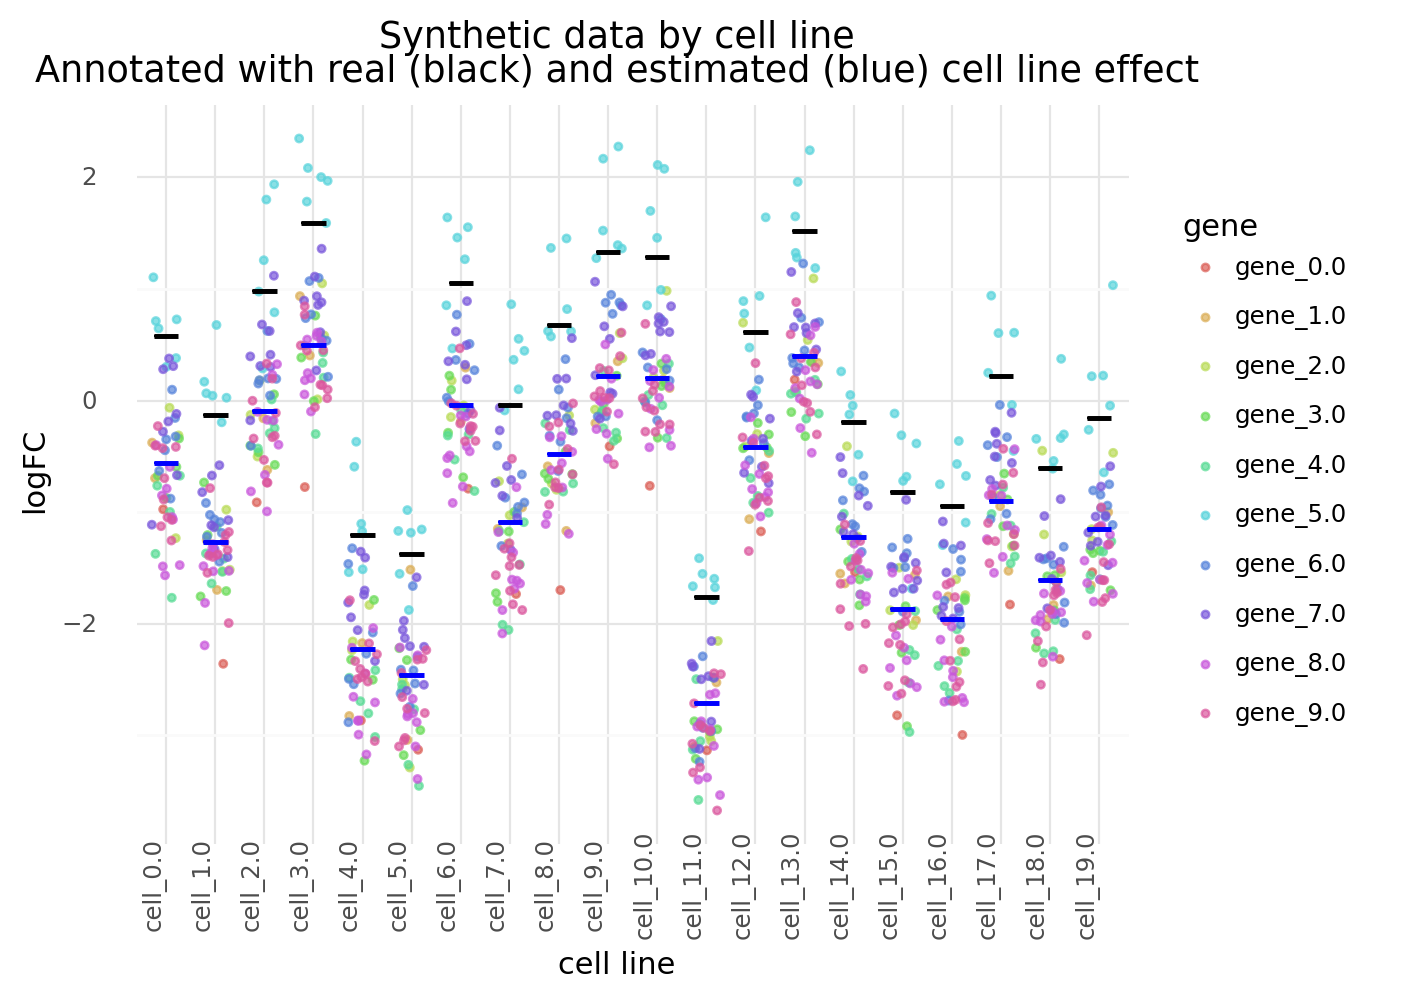

<ggplot: (8741396096946)>

In [12]:
real_cellline_vals = pd.DataFrame({"cell_line": cell_lines, "log_fc": RP["beta_c"]})
cell_line_posteriors = (
    m7a_post[["cell_line", "mean"]].groupby("cell_line").mean().reset_index()
)

(
    gg.ggplot(data, gg.aes(x="cell_line", y="log_fc"))
    + gg.geom_jitter(gg.aes(color="gene"), height=0, width=0.3, alpha=0.7, size=1)
    + gg.geom_crossbar(gg.aes(ymin="log_fc", ymax="log_fc"), data=real_cellline_vals)
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"),
        data=cell_line_posteriors,
        color="blue",
    )
    + gg.scale_color_discrete(guide=gg.guide_legend(title="gene", ncol=1))
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=1, vjust=0.5))
    + gg.labs(
        x="cell line",
        y="logFC",
        title="Synthetic data by cell line\nAnnotated with real (black) and estimated (blue) cell line effect",
    )
)

A model with complete pooling of the data to compare with the hierarhical model to highlight the effects of partial pooling.

In [13]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7a_pool:

    # Linear model parameters
    alpha_gc = pm.Normal("alpha_gc", 0, 5, shape=(num_genes, num_cell_lines))

    # Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_gc[gene_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7a_pool_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7a_pool_trace = pm.sample(
        2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95
    )
    m7a_pool_post_check = pm.sample_posterior_predictive(
        m7a_pool_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_gc]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


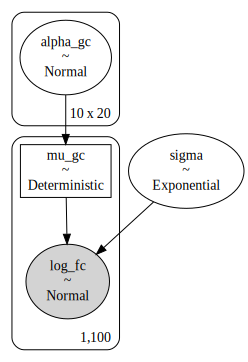

In [14]:
pm.model_to_graphviz(m7a_pool)

In [15]:
az_m7a_pool = az.from_pymc3(
    trace=m7a_pool_trace,
    model=m7a_pool,
    posterior_predictive=m7a_pool_post_check,
    prior=m7a_pool_prior_check,
)

In [16]:
m7a_pool_post = (
    az.summary(az_m7a_pool, var_names=["alpha_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7a_pool_post.head(n=10)

intercept   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
0  alpha_gc[0,0] -0.966  0.340  -1.615   -0.333      0.003    0.002   12413.0   
1  alpha_gc[0,1] -2.349  0.348  -3.020   -1.710      0.003    0.002   11758.0   
2  alpha_gc[0,2] -0.907  0.340  -1.550   -0.274      0.003    0.002   11552.0   
3  alpha_gc[0,3] -0.770  0.351  -1.399   -0.085      0.003    0.002   13773.0   
4  alpha_gc[0,4] -2.849  0.347  -3.503   -2.186      0.003    0.002   15364.0   
5  alpha_gc[0,5] -3.114  0.356  -3.748   -2.426      0.003    0.002   15264.0   
6  alpha_gc[0,6] -0.793  0.345  -1.445   -0.134      0.003    0.002   12937.0   
7  alpha_gc[0,7] -1.723  0.352  -2.413   -1.105      0.003    0.002   12401.0   
8  alpha_gc[0,8] -1.690  0.347  -2.317   -1.028      0.003    0.002   13534.0   
9  alpha_gc[0,9] -0.413  0.346  -1.064    0.233      0.003    0.003   14611.0   

    ess_sd  ess_bulk  ess_tail  r_hat  gene_idx  cell_line_idx      gene  \
0  10757.0   12382.0    5739.0    1.0         0              0  gene_0.0   
1  11251.0   11762.0    5584.0    1.0         0              1  gene_0.0   
2   9620.0   11581.0    5955.0    1.0         0              2  gene_0.0   
3  10072.0   13783.0    5782.0    1.0         0              3  gene_0.0   
4  14853.0   15340.0    6178.0    1.0         0              4  gene_0.0   
5  15264.0   15290.0    5429.0    1.0         0              5  gene_0.0   
6  10412.0   12951.0    6447.0    1.0         0              6  gene_0.0   
7  11951.0   12422.0    5660.0    1.0         0              7  gene_0.0   
8  12979.0   13550.0    5134.0    1.0         0              8  gene_0.0   
9   7202.0   14599.0    5734.0    1.0         0              9  gene_0.0   

  cell_line  
0  cell_0.0  
1  cell_1.0  
2  cell_2.0  
3  cell_3.0  
4  cell_4.0  
5  cell_5.0  
6  cell_6.0  
7  cell_7.0  
8  cell_8.0  
9  cell_9.0

Note that there is more pooling in the first genes than the later genes.
The first gene has 1 sgRNA and the last gene has 10 sgRNA.

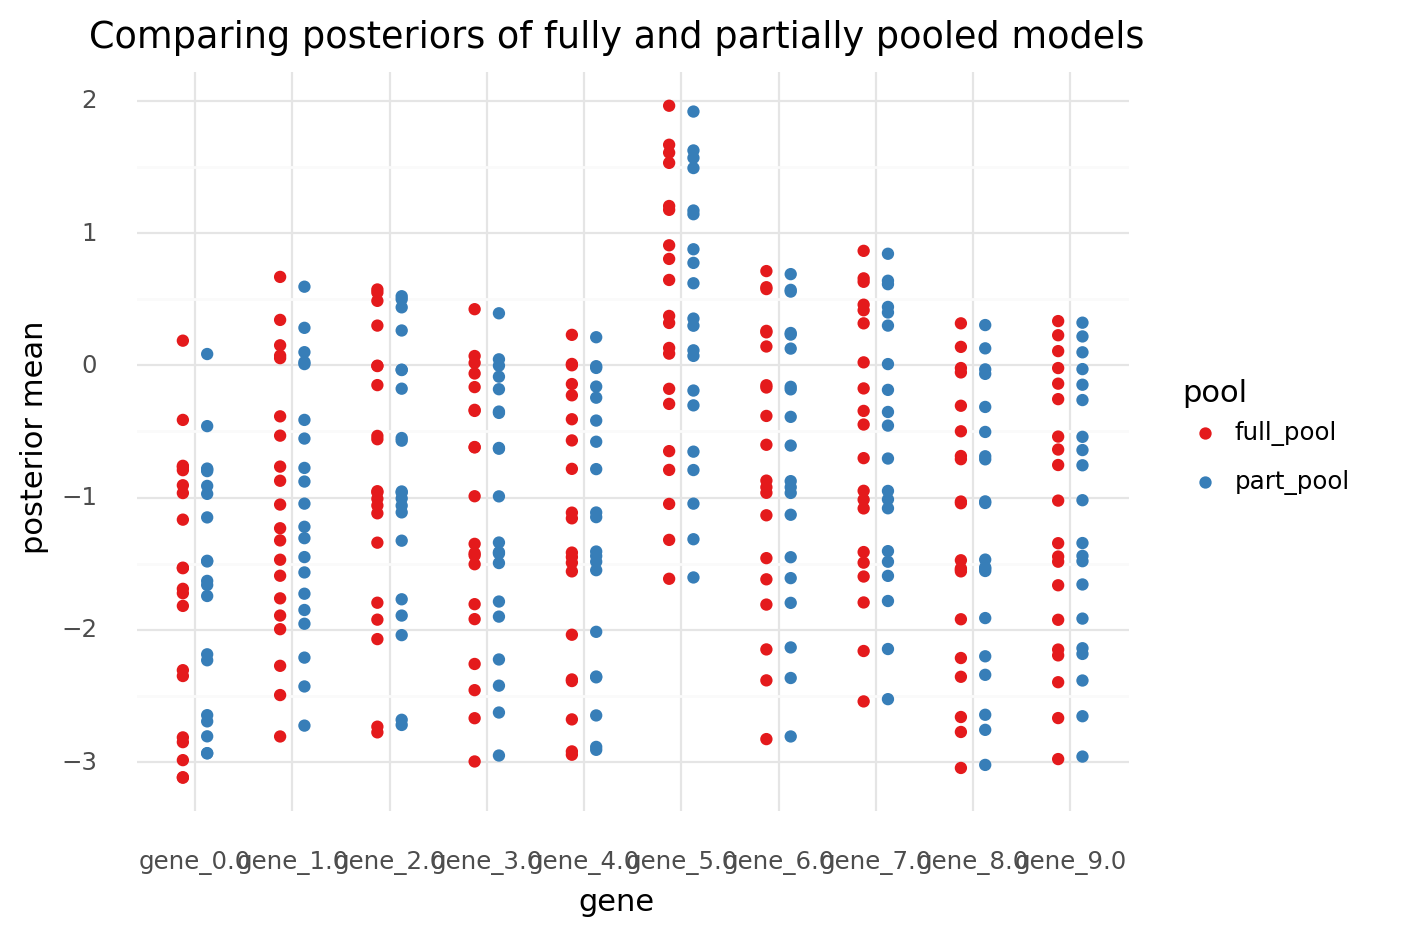

<ggplot: (8741395543944)>

In [17]:
var_names = ["gene", "cell_line", "mean"]
m7a_compare_post = pd.merge(
    m7a_post[var_names].rename(columns={"mean": "part_pool"}),
    m7a_pool_post[var_names].rename(columns={"mean": "full_pool"}),
    on=["gene", "cell_line"],
).melt(id_vars=["gene", "cell_line"], var_name="pool", value_name="mean")

for col in ["gene", "cell_line"]:
    m7a_compare_post = make_cat(m7a_compare_post, col)

(
    gg.ggplot(m7a_compare_post, gg.aes(x="gene", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="gene",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

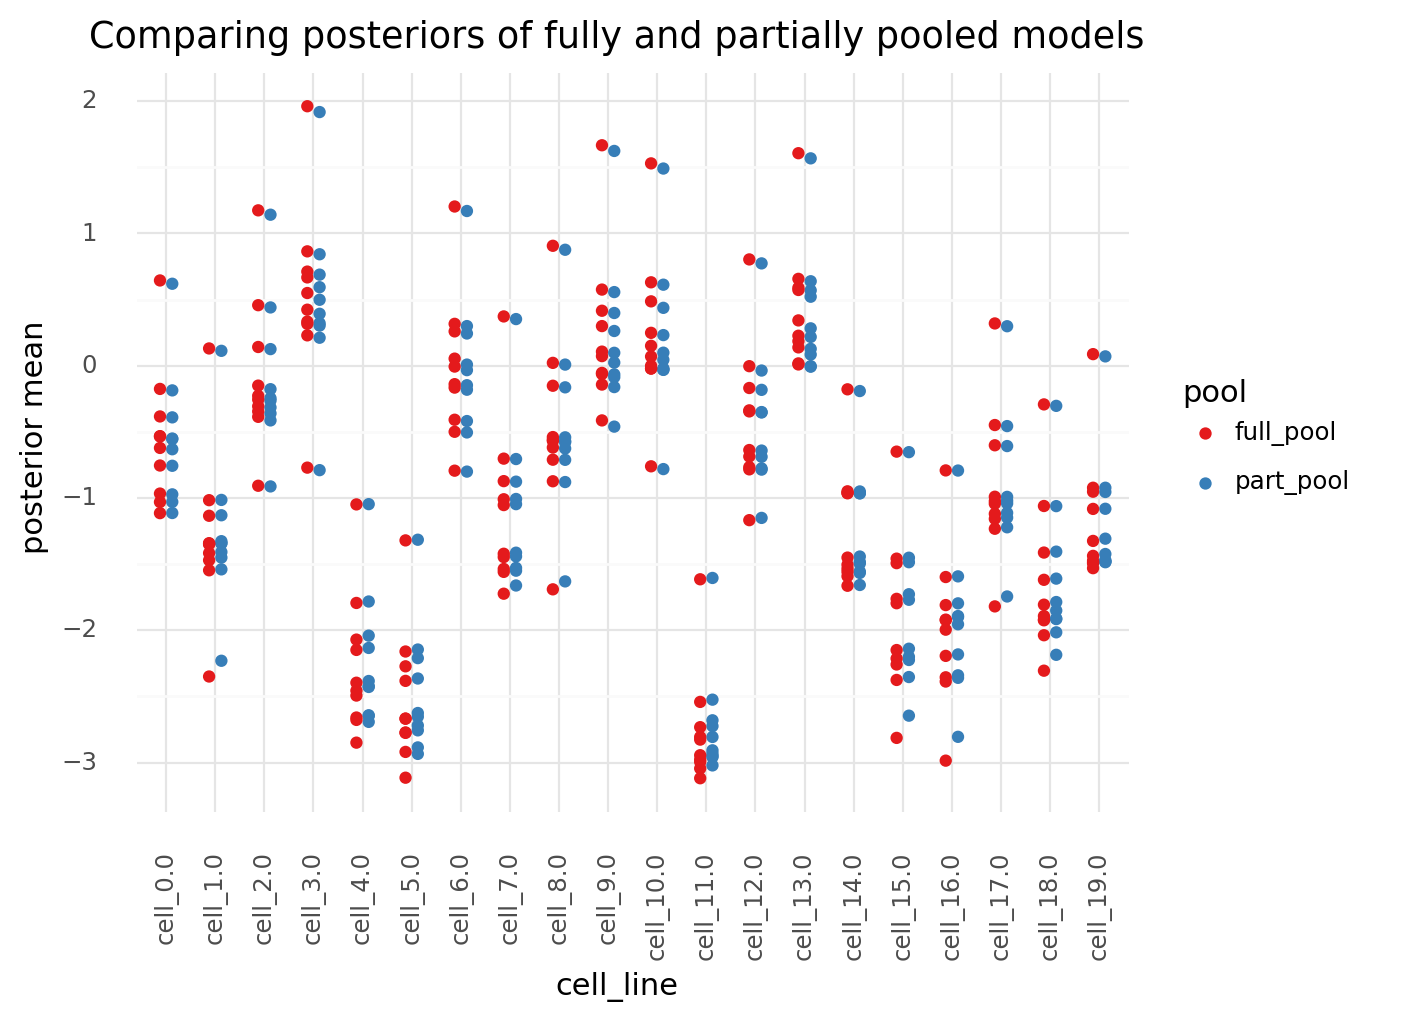

<ggplot: (8741432651319)>

In [18]:
(
    gg.ggplot(m7a_compare_post, gg.aes(x="cell_line", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.5))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(
        x="cell_line",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

In [19]:
az.summary(az_m7a, var_names=["mu_alpha_gc", "sigma_alpha"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha_gc -0.936  0.082  -1.094   -0.787      0.001    0.001   11858.0   
sigma_alpha  1.110  0.058   1.000    1.216      0.001    0.000   13260.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
mu_alpha_gc  11826.0   11823.0    5764.0    1.0  
sigma_alpha  13026.0   13424.0    6046.0    1.0

## Model 7b. A 2-Dimensional varying intercept with a hierarchical link between the sgRNA and gene

The same model as above, but with another hierarchcial level connecting the sgRNAs by their gene.
The first level uses a varying intercept of $[sgRNA, cell]$ which is then given a prior with a varying intercept of shape $[gene, cell]$.

$
logFC_{i,s,c} \sim \mathcal{N}(\mu_{s,c}, \sigma) \\
\mu_{s,c} = \alpha_{s,c} \\
\quad \alpha_{s,c} \sim \mathcal{N}(\mu_{\alpha_{s,c}}, \sigma_\alpha) \\
\qquad \mu_{\alpha_{s,c}} = \gamma_{g,c} \\
\qquad\quad \gamma_{g,c} \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0,5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [20]:
sgrna_idx = data.sgRNA.cat.codes.to_list()
gene_idx = data.gene.cat.codes.to_list()
sgrna_to_gene_idx = sgrna_df.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7b:
    # Priors for varying intercept for [gene, cell line].
    mu_gamma = pm.Normal("mu_gamma", 0, 5)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)

    # Varying intercept for [gene, cell line].
    gamma_gc = pm.Normal(
        "gamma_gc", mu_gamma, sigma_gamma, shape=(num_genes, num_cell_lines)
    )

    # Priors for varying intercept for [sgRNA, cell line].
    mu_alpha_sc = pm.Deterministic(
        "mu_alpha_sc",
        gamma_gc[
            sgrna_to_gene_idx,
        ],
    )
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    # Varying intercept for [sgRNA, cell line].
    alpha_sc = pm.Normal(
        "alpha_sc", mu_alpha_sc, sigma_alpha, shape=(num_sgrnas, num_cell_lines)
    )

    # level 0. Linear model
    mu_sc = pm.Deterministic("mu_gc", alpha_sc[sgrna_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_sc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7b_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7b_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7b_post_check = pm.sample_posterior_predictive(m7b_trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_sc, sigma_alpha, gamma_gc, sigma_gamma, mu_gamma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 149 seconds.
The acceptance probability does not match the target. It is 0.9018412241874492, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8518349990347887, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8414301759523581, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


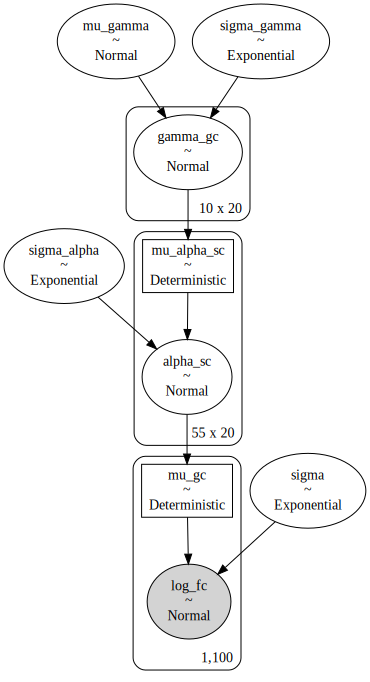

In [21]:
pm.model_to_graphviz(m7b)

In [22]:
az_m7b = az.from_pymc3(
    trace=m7b_trace,
    model=m7b,
    posterior_predictive=m7b_post_check,
    prior=m7b_prior_check,
)

Again, to identify the effects of the hierarchcial model on sharing of data, below is a non-hierarchical equivalent.

In [23]:
sgrna_idx = data.sgRNA.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7b_pool:

    # Linear model parameters
    alpha_sc = pm.Normal("alpha_sc", 0, 5, shape=(num_sgrnas, num_cell_lines))

    # Linear model
    mu_sc = pm.Deterministic("mu_sc", alpha_sc[sgrna_idx, cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_sc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7b_pool_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7b_pool_trace = pm.sample(
        2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95
    )
    m7b_pool_post_check = pm.sample_posterior_predictive(
        m7b_pool_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_sc]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 49 seconds.
The acceptance probability does not match the target. It is 0.8481062213676296, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867730747877303, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.842849433900245, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900496404543358, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


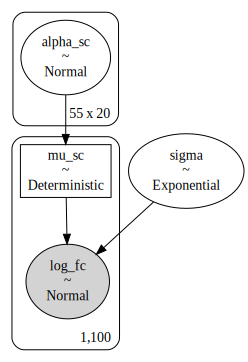

In [24]:
pm.model_to_graphviz(m7b_pool)

In [25]:
az_m7b_pool = az.from_pymc3(
    trace=m7b_pool_trace,
    model=m7b_pool,
    posterior_predictive=m7b_pool_post_check,
    prior=m7b_pool_prior_check,
)

In [26]:
az.summary(az_m7b, var_names=["mu_gamma", "sigma_gamma"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_gamma    -0.935  0.079  -1.075   -0.778      0.001    0.001    8078.0   
sigma_gamma  1.112  0.058   1.001    1.221      0.001    0.000    7646.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
mu_gamma     8078.0    8098.0    5558.0    1.0  
sigma_gamma  7570.0    7706.0    5474.0    1.0

In [27]:
m7b_post = (
    az.summary(az_m7b, var_names=["gamma_gc"])
    .reset_index()
    .rename(columns={"index": "intercept"})
    .assign(
        gene_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
        cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
    )
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)
m7b_post.head(n=10)

intercept   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
0  gamma_gc[0,0] -0.964  0.328  -1.594   -0.363      0.005    0.003    4996.0   
1  gamma_gc[0,1] -2.232  0.334  -2.862   -1.611      0.005    0.003    4665.0   
2  gamma_gc[0,2] -0.915  0.332  -1.542   -0.304      0.005    0.004    4198.0   
3  gamma_gc[0,3] -0.791  0.332  -1.391   -0.136      0.005    0.003    4739.0   
4  gamma_gc[0,4] -2.686  0.329  -3.299   -2.057      0.005    0.003    4938.0   
5  gamma_gc[0,5] -2.933  0.336  -3.558   -2.297      0.005    0.004    4063.0   
6  gamma_gc[0,6] -0.799  0.330  -1.407   -0.173      0.005    0.003    4830.0   
7  gamma_gc[0,7] -1.661  0.338  -2.292   -1.027      0.005    0.003    5467.0   
8  gamma_gc[0,8] -1.625  0.330  -2.223   -0.982      0.005    0.003    4935.0   
9  gamma_gc[0,9] -0.457  0.326  -1.066    0.162      0.004    0.003    5273.0   

   ess_sd  ess_bulk  ess_tail  r_hat  gene_idx  cell_line_idx      gene  \
0  4820.0    4994.0    5109.0    1.0         0              0  gene_0.0   
1  4665.0    4661.0    5234.0    1.0         0              1  gene_0.0   
2  4198.0    4194.0    5345.0    1.0         0              2  gene_0.0   
3  4642.0    4735.0    5011.0    1.0         0              3  gene_0.0   
4  4938.0    4942.0    5124.0    1.0         0              4  gene_0.0   
5  4050.0    4065.0    4757.0    1.0         0              5  gene_0.0   
6  4712.0    4837.0    5221.0    1.0         0              6  gene_0.0   
7  5338.0    5470.0    5188.0    1.0         0              7  gene_0.0   
8  4935.0    4954.0    4710.0    1.0         0              8  gene_0.0   
9  5180.0    5284.0    5238.0    1.0         0              9  gene_0.0   

  cell_line  
0  cell_0.0  
1  cell_1.0  
2  cell_2.0  
3  cell_3.0  
4  cell_4.0  
5  cell_5.0  
6  cell_6.0  
7  cell_7.0  
8  cell_8.0  
9  cell_9.0

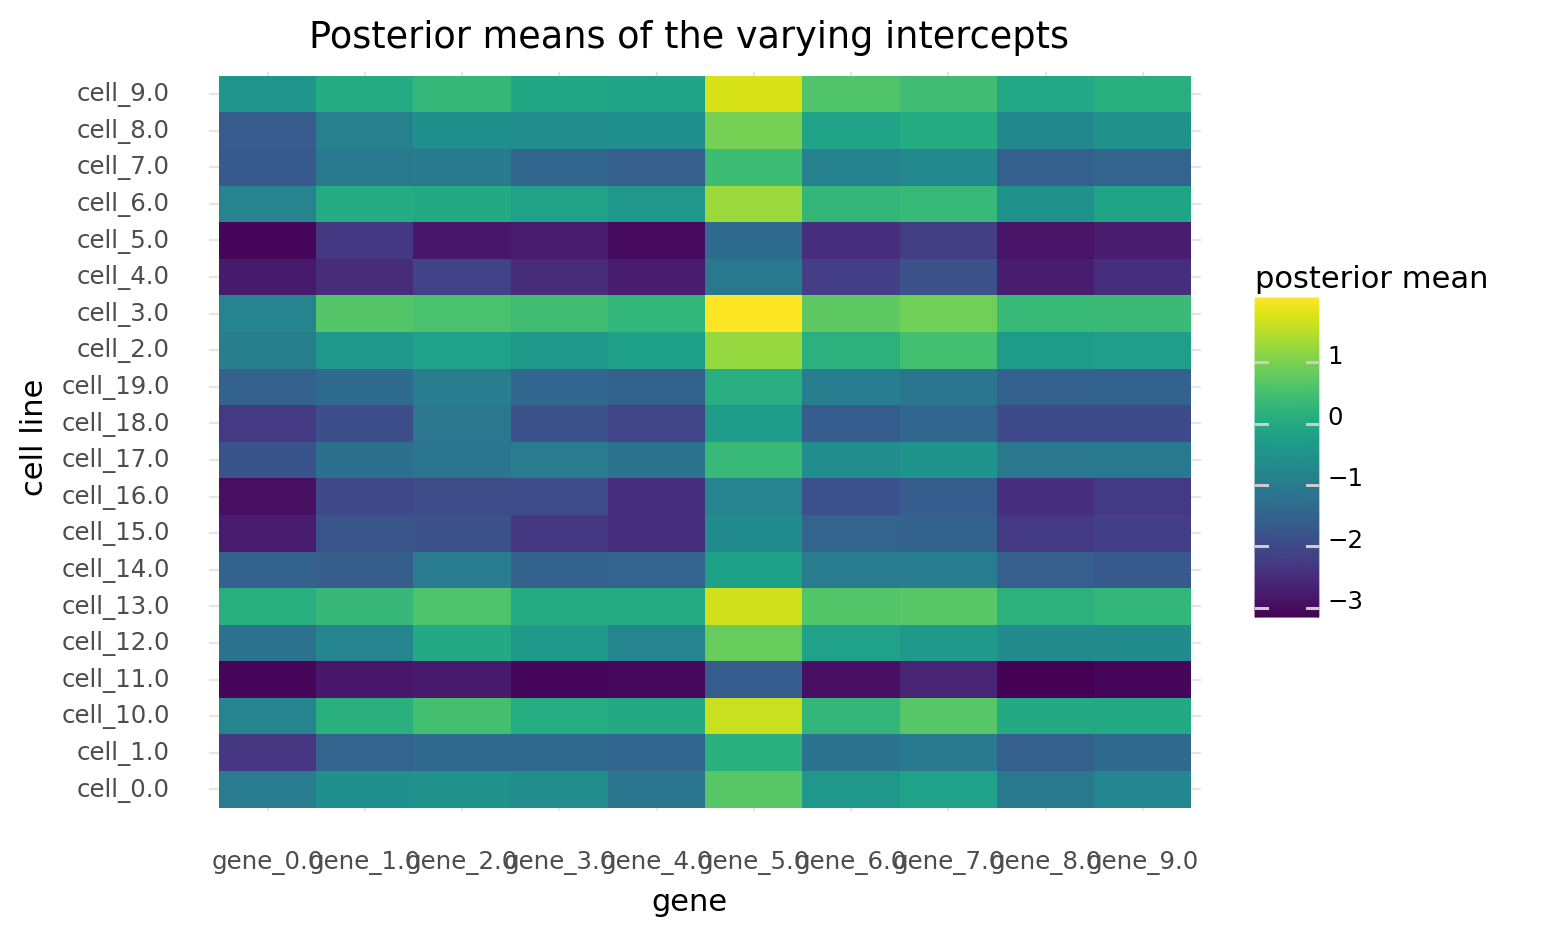

<ggplot: (8741432533622)>

In [28]:
(
    gg.ggplot(m7b_post, gg.aes(x="gene", y="cell_line"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.labs(
        x="gene",
        y="cell line",
        fill="posterior mean",
        title="Posterior means of the varying intercepts",
    )
)

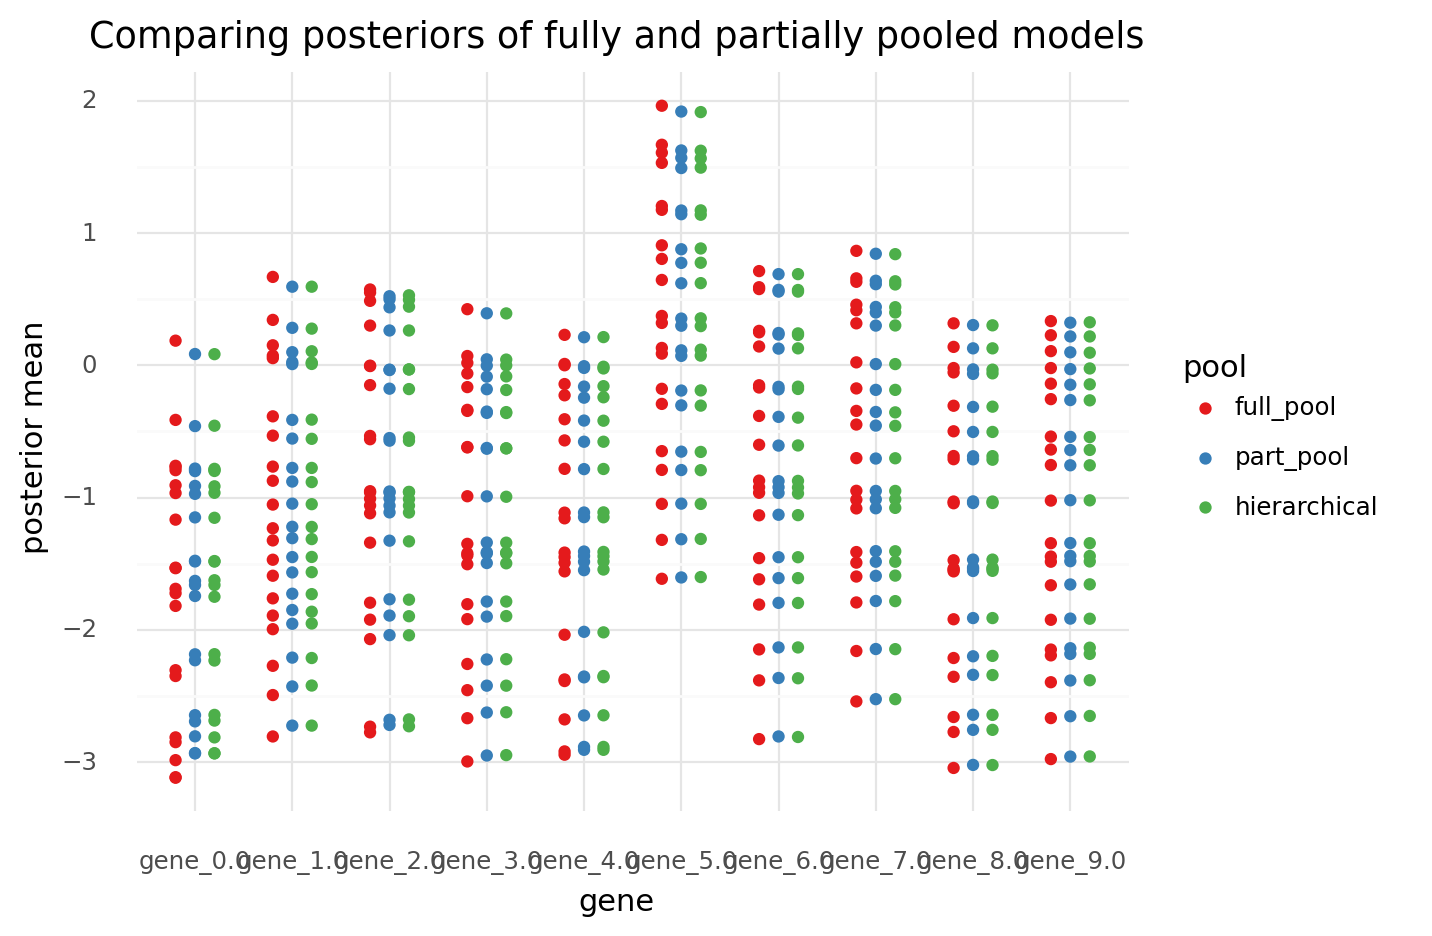

<ggplot: (8741441154988)>

In [29]:
var_names = ["gene", "cell_line", "mean"]
m7ab_compare_post = (
    pd.merge(
        m7a_pool_post[var_names].rename(columns={"mean": "full_pool"}),
        m7a_post[var_names].rename(columns={"mean": "part_pool"}),
        on=["gene", "cell_line"],
    )
    .merge(
        m7b_post[var_names].rename(columns={"mean": "hierarchical"}),
        on=["gene", "cell_line"],
    )
    .melt(id_vars=["gene", "cell_line"], var_name="pool", value_name="mean")
)

for col in ["gene", "cell_line", "pool"]:
    m7ab_compare_post = make_cat(m7ab_compare_post, col)


(
    gg.ggplot(m7ab_compare_post, gg.aes(x="gene", y="mean"))
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.6))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="gene",
        y="posterior mean",
        title="Comparing posteriors of fully and partially pooled models",
    )
)

In [30]:
def parse_alpha_sc(az_obj: az.InferenceData) -> pd.DataFrame:
    post_df = (
        az.summary(az_obj, var_names=["alpha_sc"])
        .reset_index()
        .rename(columns={"index": "intercept"})
        .assign(
            sgrna_idx=lambda d: d["intercept"].str.extract(r"\[(\d+),"),
            cell_line_idx=lambda d: d["intercept"].str.extract(r",(\d+)\]"),
        )
        .assign(
            sgrna_idx=lambda d: [int(x) for x in d.sgrna_idx],
            sgRNA=lambda d: [sgrnas[i] for i in d.sgrna_idx],
            cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
            cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
            gene=lambda d: [genes[sgrna_to_gene_idx[i]] for i in d.sgrna_idx],
        )
    )

    for col in ["gene", "cell_line", "sgRNA"]:
        post_df = make_cat(post_df, col)

    return post_df


m7b_alpha_sc = parse_alpha_sc(az_m7b)
m7b_pool_alpha_sc = parse_alpha_sc(az_m7b_pool)

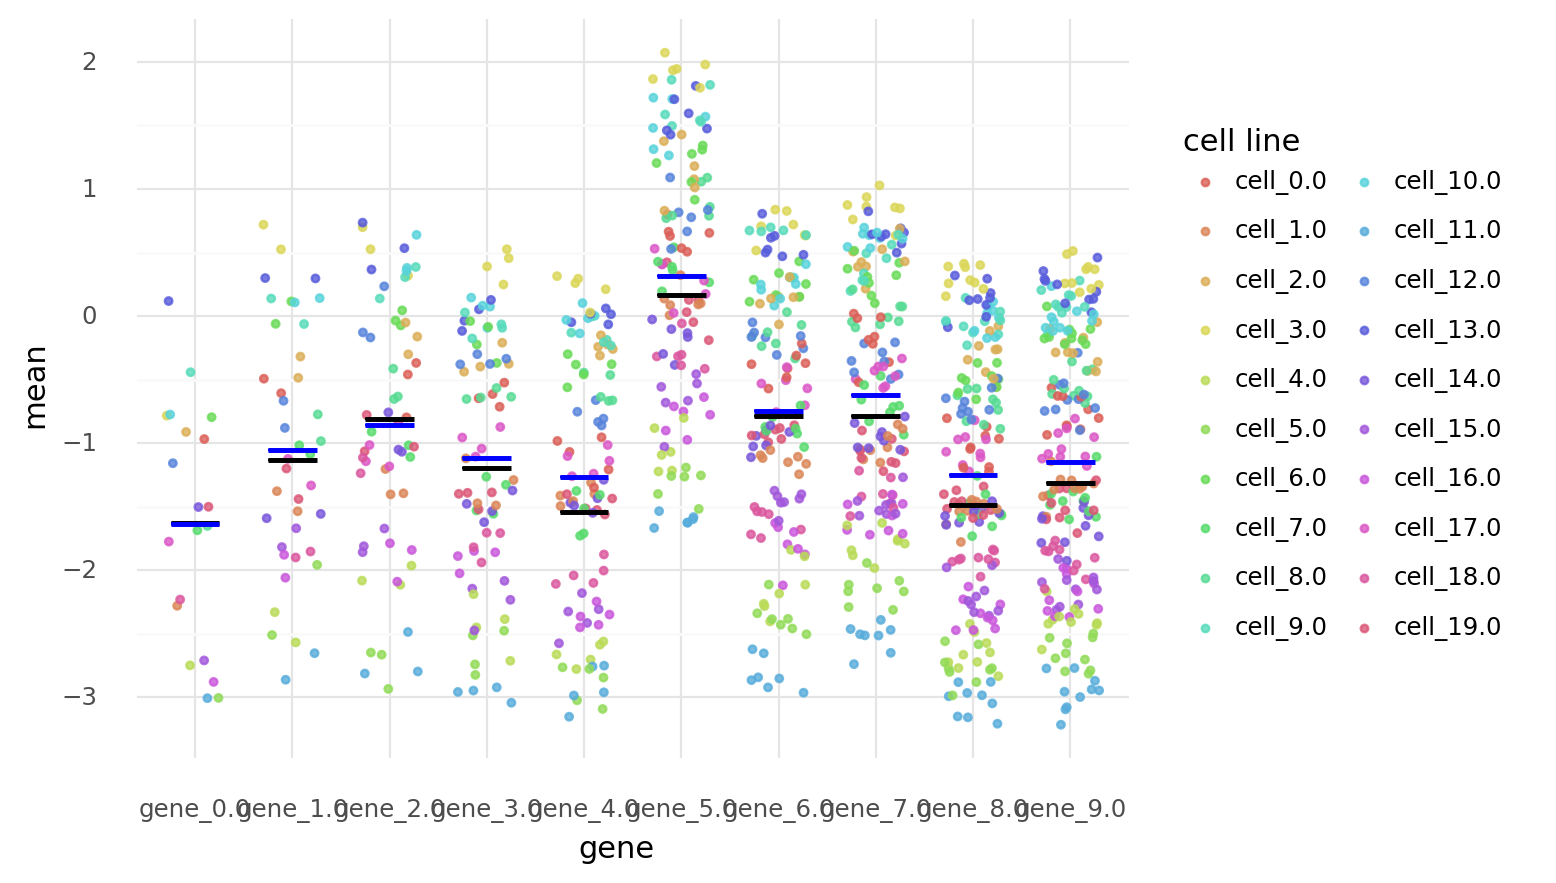

<ggplot: (8741395469936)>

In [31]:
gene_posteriors = m7b_alpha_sc[["gene", "mean"]].groupby("gene").mean().reset_index()

(
    gg.ggplot(m7b_alpha_sc, gg.aes(x="gene", y="mean"))
    + gg.geom_jitter(gg.aes(color="cell_line"), height=0, width=0.3, alpha=0.8, size=1)
    + gg.scale_color_discrete(guide=gg.guide_legend(title="cell line", ncol=2))
    + gg.geom_crossbar(
        gg.aes(ymin="log_fc", ymax="log_fc", y="log_fc"), data=real_gene_vals
    )
    + gg.geom_crossbar(
        gg.aes(ymin="mean", ymax="mean", y="mean"), data=gene_posteriors, color="blue"
    )
)

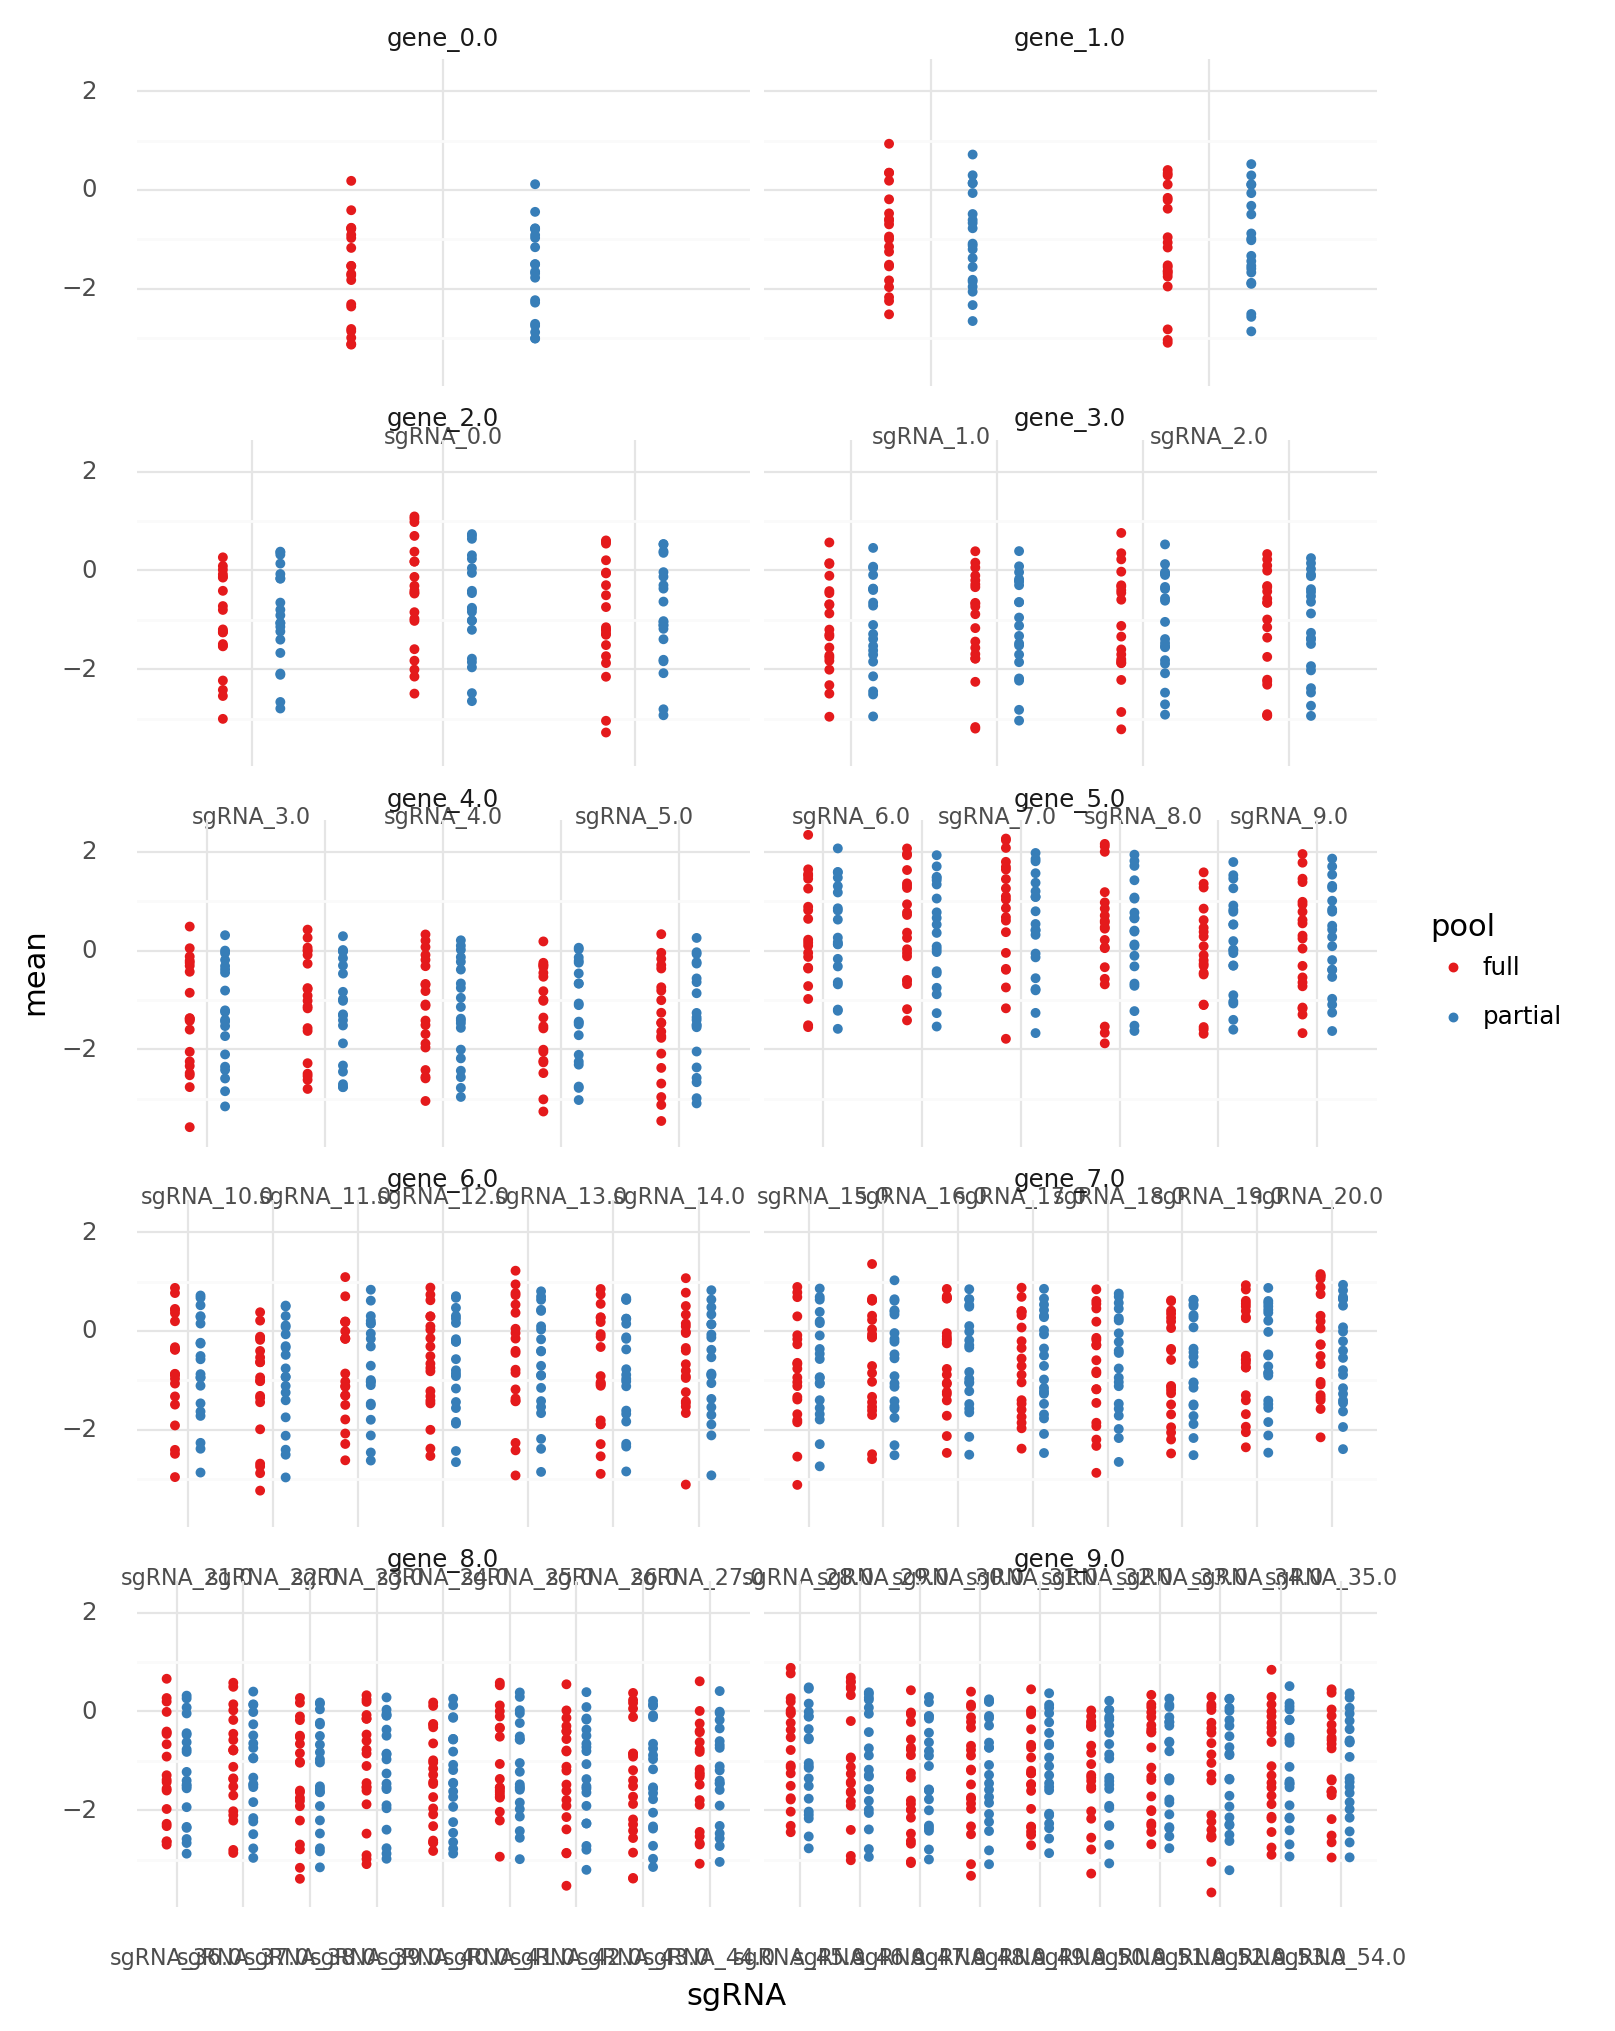

<ggplot: (8741395547085)>

In [32]:
compare_alpha_sc = pd.concat(
    [m7b_alpha_sc.assign(pool="partial"), m7b_pool_alpha_sc.assign(pool="full")]
)

(
    gg.ggplot(compare_alpha_sc, gg.aes(x="sgRNA", y="mean"))
    + gg.facet_wrap("gene", ncol=2, scales="free_x")
    + gg.geom_point(gg.aes(color="pool"), position=gg.position_dodge(width=0.6), size=1)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(8, 12), axis_text_x=gg.element_text(size=8))
)

One issue is still that the cell line and gene effects are muddled and inseparable.
Therefore, drawing useful conclusions about the impact of knocking out a gene using a specific guide is very difficult, potentially impossible.

In [33]:
pred_alpha_s = sgrna_df.copy()
m7b_alpha_sc_post = m7b_trace.get_values("alpha_sc")

# For each posterior sample, the average for each cell line.
cell_line_avg = m7b_alpha_sc_post.mean(axis=1)

for i in range(len(pred_alpha_s)):
    p = (m7b_alpha_sc_post[:, i, :] - cell_line_avg).flatten()
    pred_alpha_s.loc[i, "mean"] = np.mean(p)
    hdi = az.hdi(p, hdi_prob=0.89)
    pred_alpha_s.loc[i, "hdi_89_lower"] = hdi[0]
    pred_alpha_s.loc[i, "hdi_89_upper"] = hdi[1]

pred_alpha_s["real_value"] = RP["alpha_s"]
pred_alpha_s

gene       sgRNA      mean  hdi_89_lower  hdi_89_upper  real_value
0   gene_0.0   sgRNA_0.0 -0.759158     -1.429401     -0.086850   -1.862128
1   gene_1.0   sgRNA_1.0 -0.140265     -0.637390      0.334182   -1.070338
2   gene_1.0   sgRNA_2.0 -0.224691     -0.728134      0.285135   -1.319719
3   gene_2.0   sgRNA_3.0 -0.065368     -0.531590      0.392692   -1.176780
4   gene_2.0   sgRNA_4.0  0.144408     -0.400708      0.675432   -0.645986
5   gene_2.0   sgRNA_5.0 -0.025989     -0.522190      0.464967   -0.958555
6   gene_3.0   sgRNA_6.0 -0.253599     -0.635382      0.128207   -1.280025
7   gene_3.0   sgRNA_7.0 -0.225569     -0.644519      0.181863   -1.183275
8   gene_3.0   sgRNA_8.0 -0.241341     -0.638887      0.164987   -1.242896
9   gene_3.0   sgRNA_9.0 -0.258000     -0.654902      0.166913   -1.159313
10  gene_4.0  sgRNA_10.0 -0.416831     -0.795693     -0.048826   -1.409439
11  gene_4.0  sgRNA_11.0 -0.317237     -0.699618      0.065350   -1.203135
12  gene_4.0  sgRNA_12.0 -0.356737     -0.684337     -0.037109   -1.331831
13  gene_4.0  sgRNA_13.0 -0.412891     -0.800781     -0.033596   -1.484044
14  gene_4.0  sgRNA_14.0 -0.458564     -0.832220     -0.053363   -1.707468
15  gene_5.0  sgRNA_15.0  1.197364      0.862914      1.546651    0.183812
16  gene_5.0  sgRNA_16.0  1.253322      0.901795      1.610755    0.213355
17  gene_5.0  sgRNA_17.0  1.336128      0.918705      1.772030    0.506672
18  gene_5.0  sgRNA_18.0  1.174975      0.779345      1.572104    0.088151
19  gene_5.0  sgRNA_19.0  1.036560      0.633211      1.453533   -0.256121
20  gene_5.0  sgRNA_20.0  1.135561      0.749591      1.518218    0.043019
21  gene_6.0  sgRNA_21.0  0.120620     -0.243539      0.491454   -0.888385
22  gene_6.0  sgRNA_22.0 -0.013618     -0.433703      0.378880   -1.227153
23  gene_6.0  sgRNA_23.0  0.122441     -0.207457      0.455777   -0.865815
24  gene_6.0  sgRNA_24.0  0.169749     -0.198930      0.523396   -0.843903
25  gene_6.0  sgRNA_25.0  0.197040     -0.195714      0.594115   -0.730256
26  gene_6.0  sgRNA_26.0  0.104327     -0.235173      0.444894   -0.876381
27  gene_6.0  sgRNA_27.0  0.186050     -0.199568      0.574821   -0.691828
28  gene_7.0  sgRNA_28.0  0.175289     -0.183857      0.531827   -0.989358
29  gene_7.0  sgRNA_29.0  0.264822     -0.104726      0.605801   -0.749392
30  gene_7.0  sgRNA_30.0  0.275510     -0.071395      0.630757   -0.665104
31  gene_7.0  sgRNA_31.0  0.243113     -0.158649      0.620726   -0.845472
32  gene_7.0  sgRNA_32.0  0.197645     -0.138627      0.548258   -0.968587
33  gene_7.0  sgRNA_33.0  0.200275     -0.174224      0.571602   -0.924400
34  gene_7.0  sgRNA_34.0  0.295269     -0.065937      0.664482   -0.581153
35  gene_7.0  sgRNA_35.0  0.388137     -0.001969      0.775968   -0.478120
36  gene_8.0  sgRNA_36.0 -0.347147     -0.726509      0.038244   -1.384790
37  gene_8.0  sgRNA_37.0 -0.306947     -0.608779      0.004000   -1.152245
38  gene_8.0  sgRNA_38.0 -0.415836     -0.747693     -0.082078   -1.487493
39  gene_8.0  sgRNA_39.0 -0.333477     -0.703224      0.036198   -1.321872
40  gene_8.0  sgRNA_40.0 -0.416226     -0.777866     -0.064319   -1.508166
41  gene_8.0  sgRNA_41.0 -0.302155     -0.648747      0.057204   -1.283574
42  gene_8.0  sgRNA_42.0 -0.385597     -0.702265     -0.069986   -1.393158
43  gene_8.0  sgRNA_43.0 -0.439982     -0.812249     -0.088966   -1.568002
44  gene_8.0  sgRNA_44.0 -0.395876     -0.731206     -0.060454   -1.510403
45  gene_9.0  sgRNA_45.0 -0.129471     -0.474636      0.226328   -0.946443
46  gene_9.0  sgRNA_46.0 -0.209398     -0.580897      0.189292   -1.181060
47  gene_9.0  sgRNA_47.0 -0.383099     -0.739852     -0.032106   -1.594541
48  gene_9.0  sgRNA_48.0 -0.305462     -0.619763      0.008811   -1.431779
49  gene_9.0  sgRNA_49.0 -0.306052     -0.635381      0.014513   -1.365683
50  gene_9.0  sgRNA_50.0 -0.289178     -0.613271      0.036653   -1.420578
51  gene_9.0  sgRNA_51.0 -0.237110     -0.614011      0.137988   -1.221988
52  gene_9.0  sgRNA_52.0 -0.33971

## Model 7c. Two varying intercepts

Due to the issue mentioned above about the gene/sgRNA and cell line effects being combined, I want to attempt the two-varying-intercept model again.
This time, I will use more strict priors.

$
logFC_{i,s,c} \sim \mathcal{N}(\mu_{g,c}, \sigma) \\
\mu_{g,c} = \alpha_g + \beta_c \\
\quad \alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha \sim \mathcal{N}(0,5) \quad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta \sim \mathcal{N}(0,5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

In [34]:
gene_idx = data.gene.cat.codes.to_list()
cell_line_idx = data.cell_line.cat.codes.to_list()

with pm.Model() as m7c:

    # Hyper-priors
    mu_alpha = pm.Normal("mu_alpha", -1, 1)
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    mu_beta = pm.Normal("mu_beta", 0, 0.2)
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Varying intercept for gene and cell line.
    alpha_g = pm.Normal("alpha_g", mu_alpha, sigma_alpha, shape=(num_genes))
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=(num_cell_lines))

    # level 0. Linear model
    mu_gc = pm.Deterministic("mu_gc", alpha_g[gene_idx] + beta_c[cell_line_idx])
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    log_fc = pm.Normal("log_fc", mu_gc, sigma, observed=data.log_fc.to_list())

    # Sampling
    m7c_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    m7c_trace = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95)
    m7c_post_check = pm.sample_posterior_predictive(m7c_trace, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_c, alpha_g, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.
The number of effective samples is smaller than 10% for some parameters.


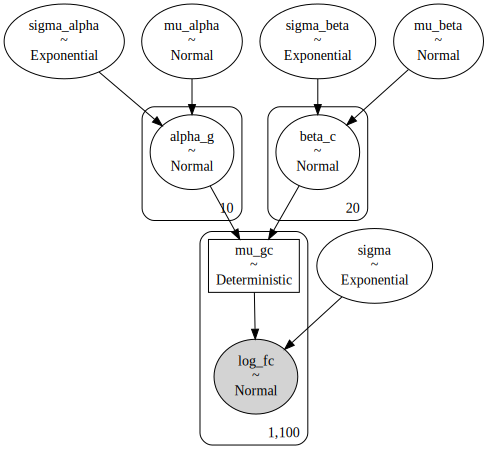

In [35]:
pm.model_to_graphviz(m7c)

In [36]:
az_m7c = az.from_pymc3(
    trace=m7c_trace,
    model=m7c,
    posterior_predictive=m7c_post_check,
    prior=m7c_prior_check,
)

This approach seems to work great!
More sampling will be required to get more effective samples of the posterior, but as a proof-of-concept, this worked.

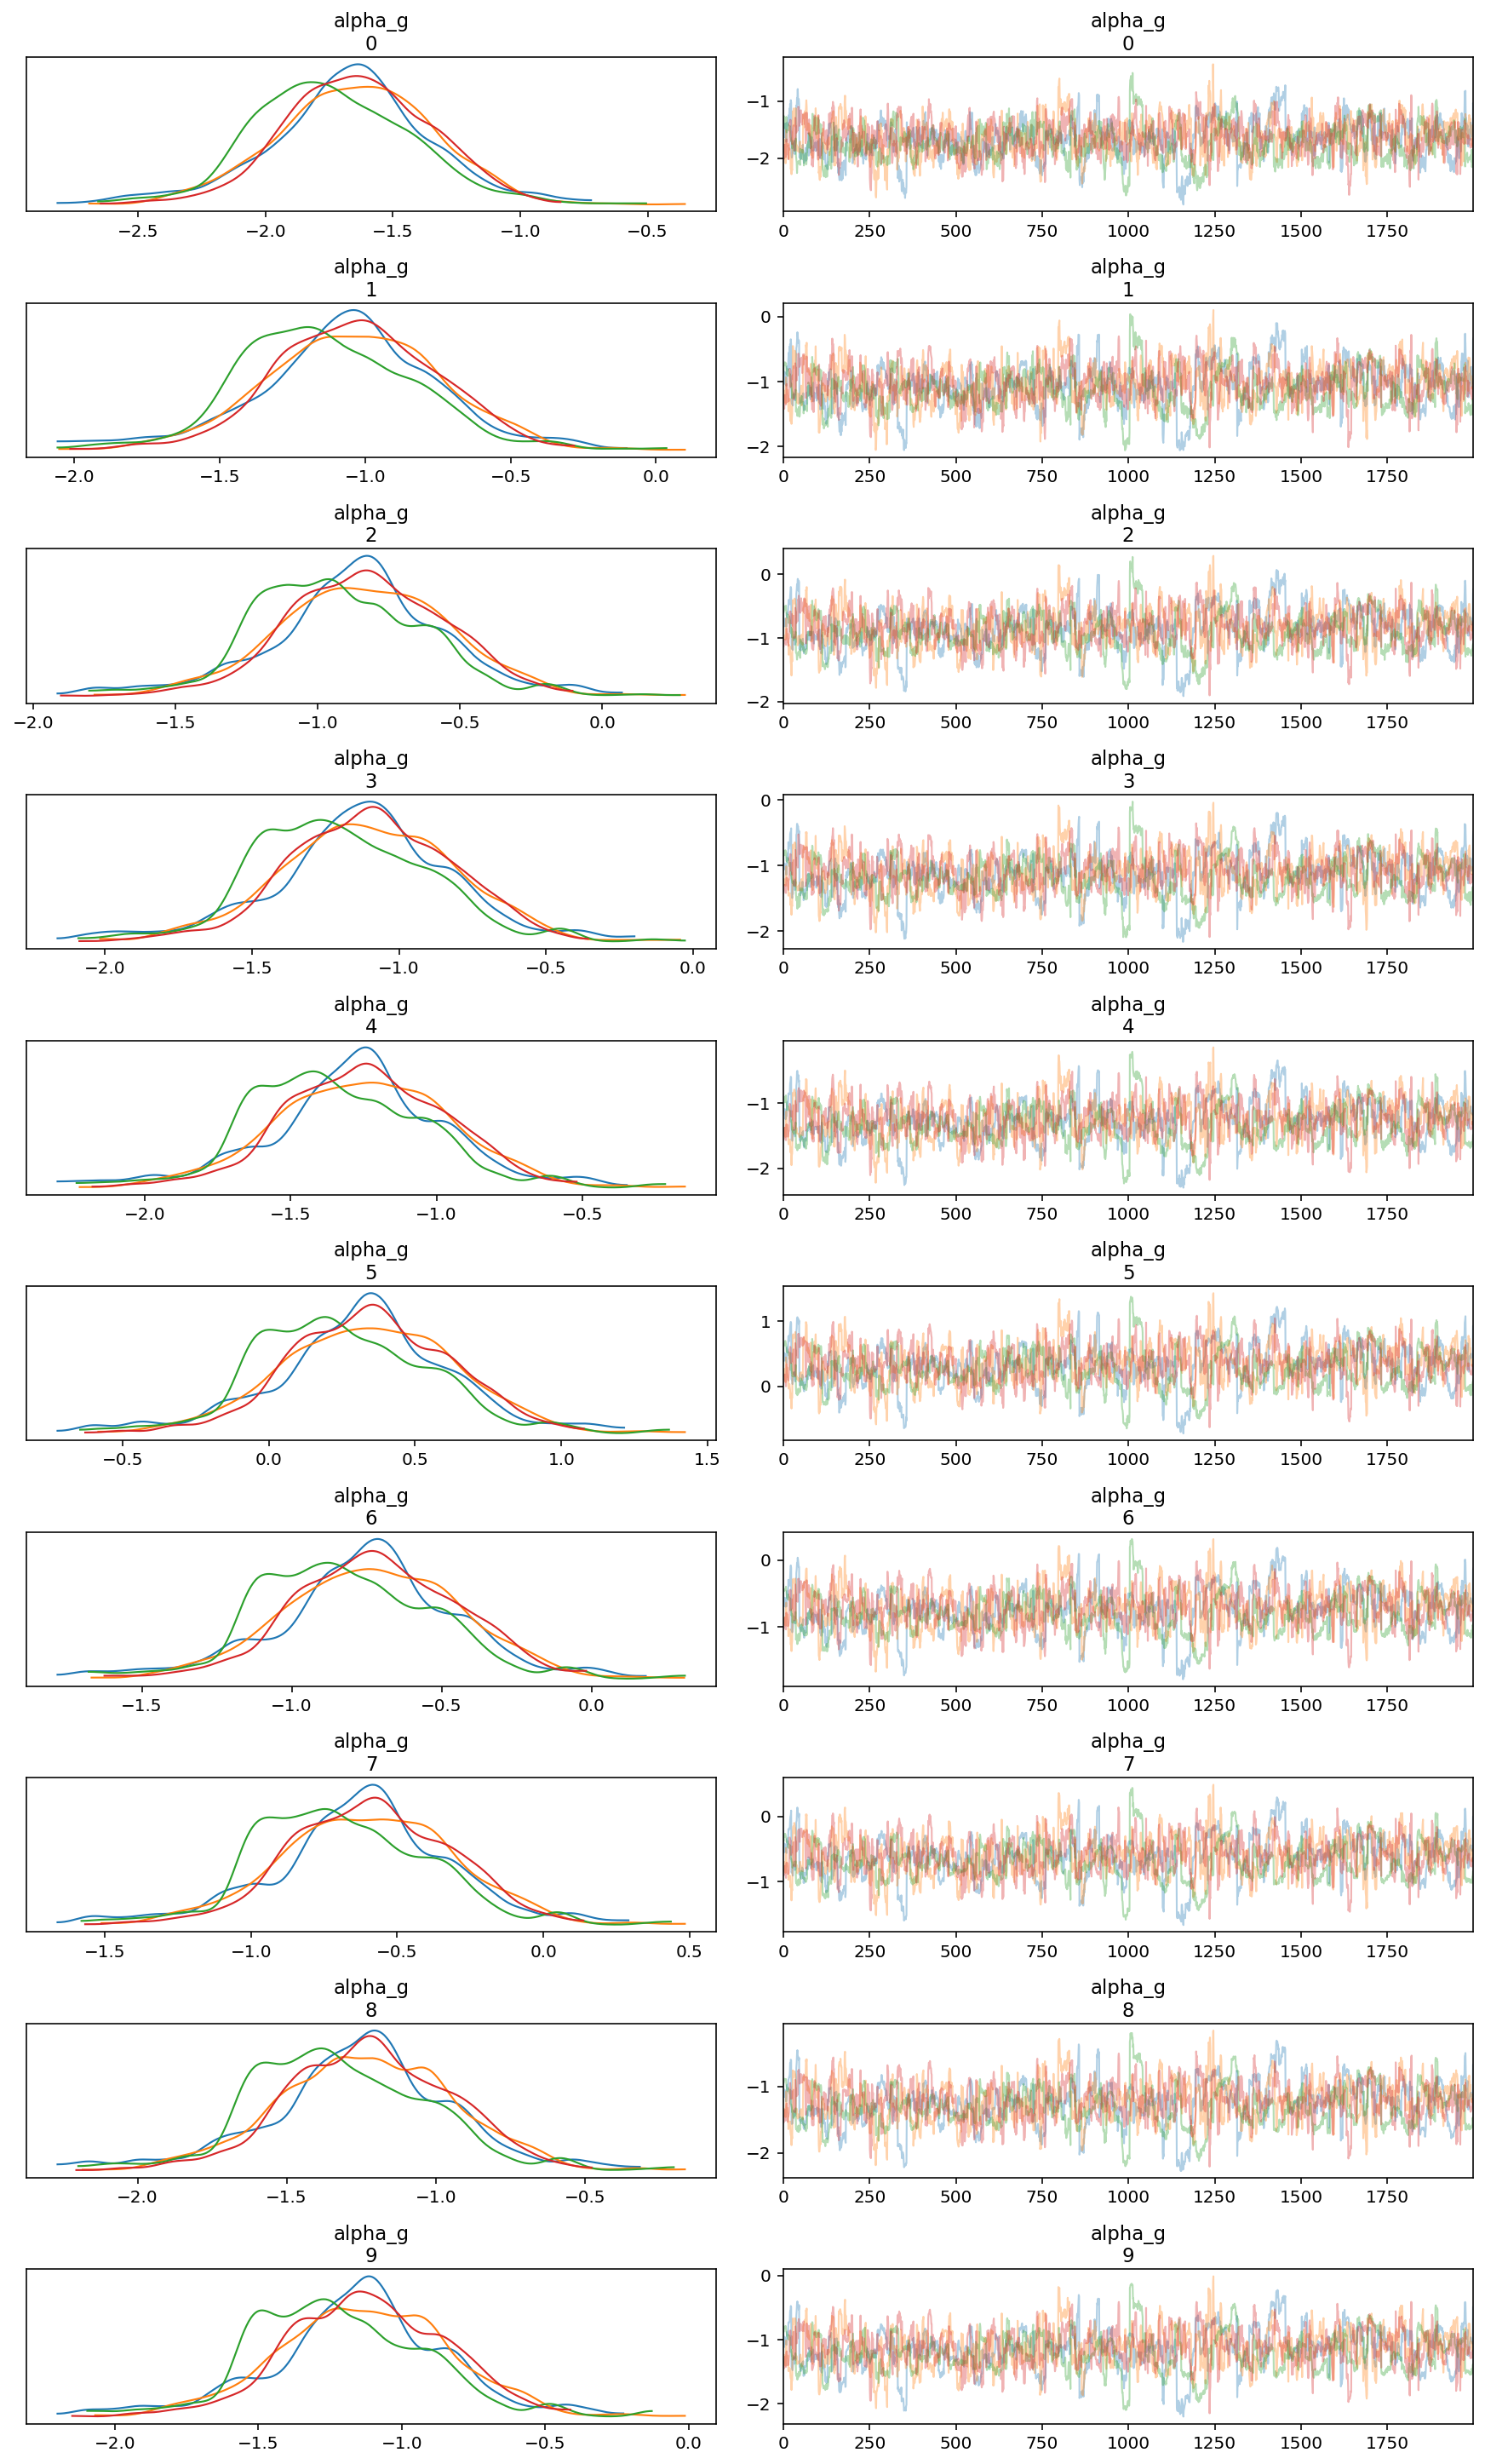

In [37]:
az.plot_trace(az_m7c, var_names="alpha_g")
plt.show()

In [38]:
az.summary(
    az_m7c, var_names=["mu_alpha", "sigma_alpha", "mu_beta", "sigma_beta"]
).assign(
    real_value=[RP[k] for k in ["mu_gamma", "sigma_gamma", "mu_beta", "sigma_beta"]]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
mu_alpha    -0.955  0.342  -1.608   -0.305      0.014    0.010     625.0   
sigma_alpha  0.599  0.166   0.341    0.897      0.004    0.003    2077.0   
mu_beta      0.004  0.200  -0.382    0.364      0.007    0.005     799.0   
sigma_beta   1.057  0.184   0.741    1.395      0.004    0.003    2634.0   

             ess_sd  ess_bulk  ess_tail  r_hat  real_value  
mu_alpha      621.0     631.0     818.0   1.01        -1.0  
sigma_alpha  2077.0    2184.0    2441.0   1.00         0.5  
mu_beta       799.0     803.0    1279.0   1.01         0.0  
sigma_beta   2609.0    2732.0    3107.0   1.00         1.0

Both the gene and cell line effects were estimated very well.
Again, the sampling was not perfect, but that can be fixed with more compute & time,

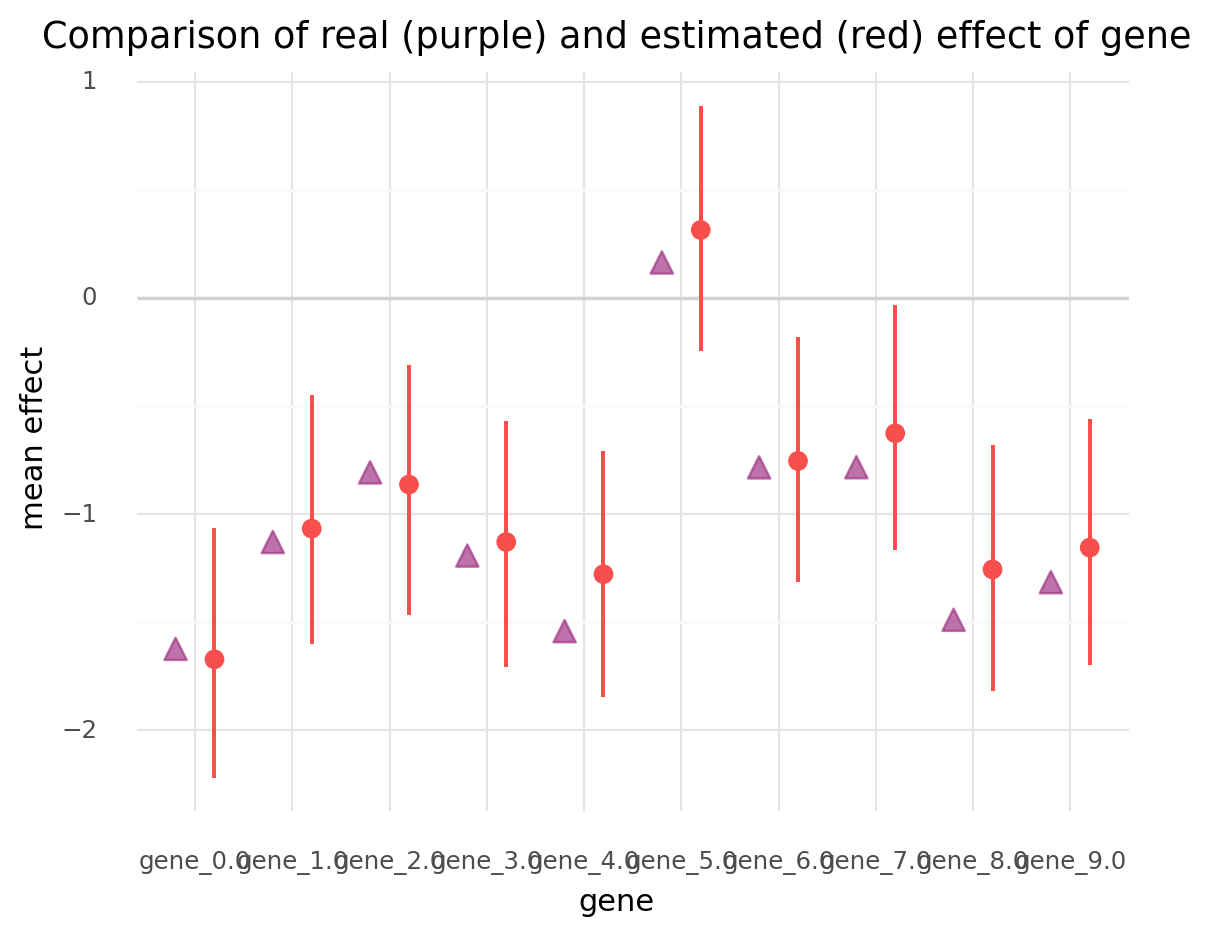

<ggplot: (8741385867671)>

In [39]:
m7c_alpha_g_post = (
    az.summary(az_m7c, var_names="alpha_g")
    .reset_index()
    .rename(columns={"index": "alpha_g"})
    .assign(gene_idx=lambda d: d["alpha_g"].str.extract(r"\[(\d+)\]"))
    .assign(
        gene_idx=lambda d: [int(x) for x in d.gene_idx],
        gene=lambda d: [genes[i] for i in d.gene_idx],
    )
)

nudge_x = 0.2
red_color = "#F84E4C"
purple_color = "#A13786"

(
    gg.ggplot(m7c_alpha_g_post, gg.aes(x="gene"))
    + gg.geom_hline(yintercept=0, size=0.7, color="lightgray")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_3%", ymax="hdi_97%"),
        color=red_color,
        size=0.8,
        position=gg.position_nudge(x=nudge_x),
    )
    + gg.geom_point(
        gg.aes(y="mean"), color=red_color, size=3, position=gg.position_nudge(x=nudge_x)
    )
    + gg.geom_point(
        gg.aes(y="log_fc"),
        data=real_gene_vals,
        color=purple_color,
        shape="^",
        size=4,
        alpha=0.7,
        position=gg.position_nudge(x=-nudge_x),
    )
    + gg.labs(
        x="gene",
        y="mean effect",
        title="Comparison of real (purple) and estimated (red) effect of gene",
    )
)

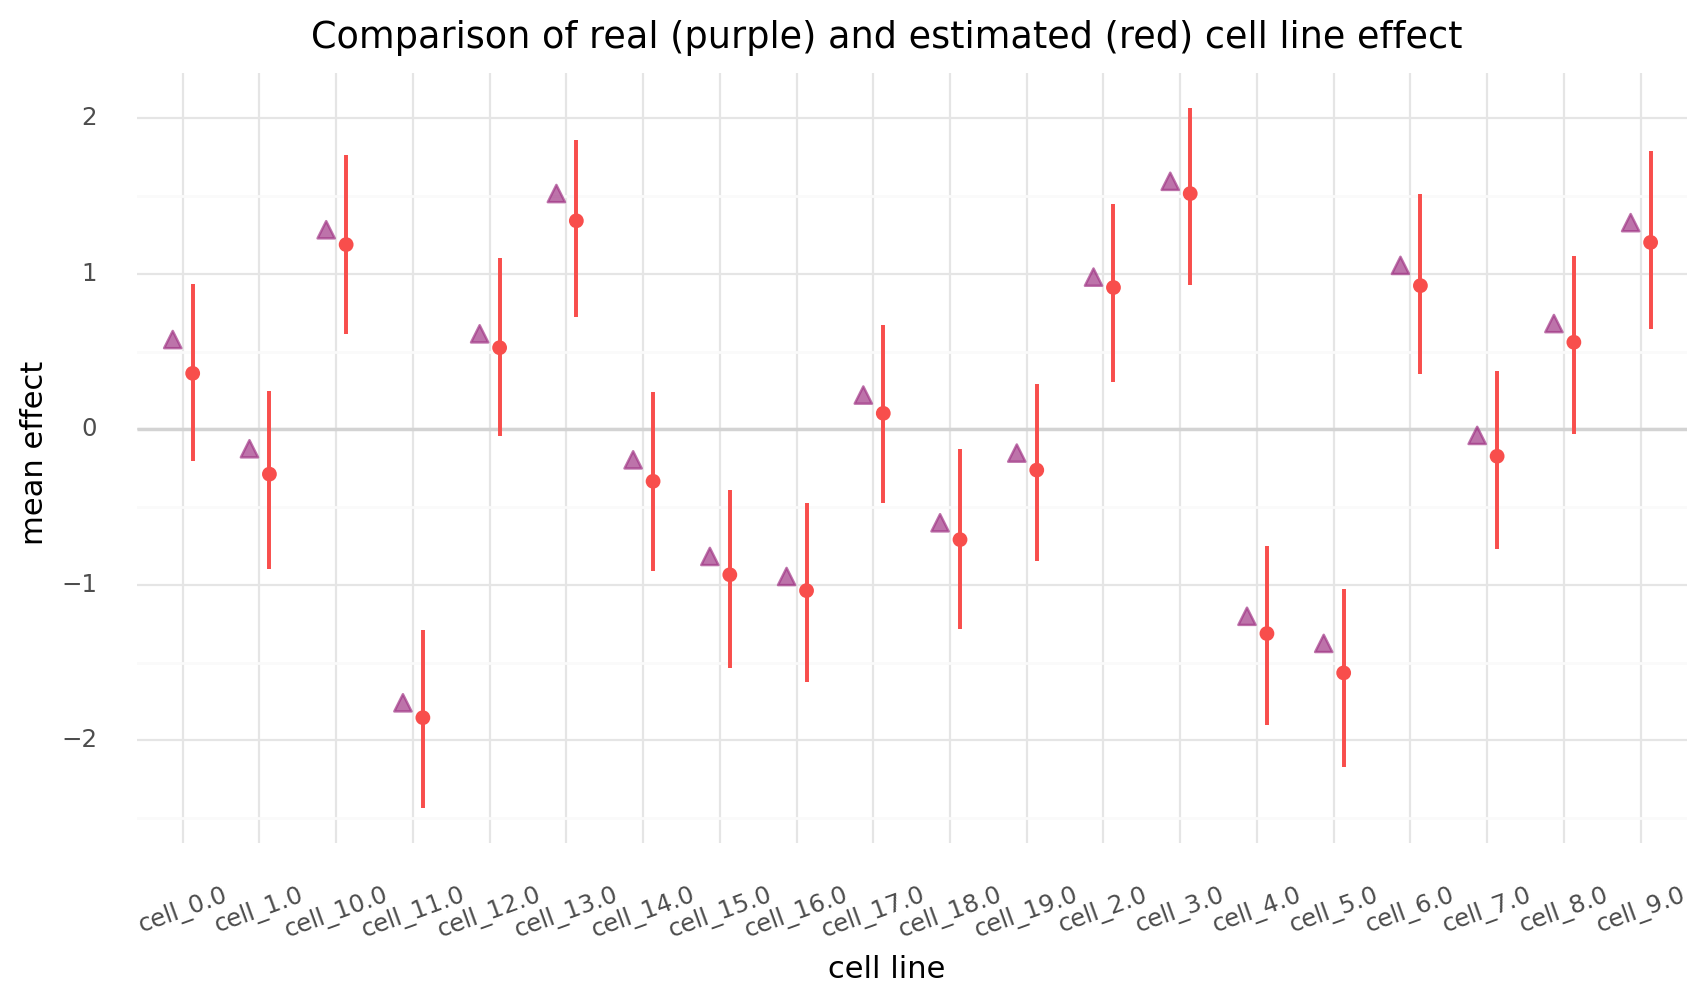

<ggplot: (8741385867716)>

In [40]:
m7c_beta_c_post = (
    az.summary(az_m7c, var_names="beta_c")
    .reset_index()
    .rename(columns={"index": "beta_c"})
    .assign(cell_line_idx=lambda d: d["beta_c"].str.extract(r"\[(\d+)\]"))
    .assign(
        cell_line_idx=lambda d: [int(x) for x in d.cell_line_idx],
        cell_line=lambda d: [cell_lines[i] for i in d.cell_line_idx],
    )
)

nudge_x = 0.13

(
    gg.ggplot(m7c_beta_c_post, gg.aes(x="cell_line"))
    + gg.geom_hline(yintercept=0, size=0.7, color="lightgray")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_3%", ymax="hdi_97%"),
        color=red_color,
        size=0.8,
        position=gg.position_nudge(x=nudge_x),
    )
    + gg.geom_point(
        gg.aes(y="mean"), color=red_color, size=2, position=gg.position_nudge(x=nudge_x)
    )
    + gg.geom_point(
        gg.aes(y="log_fc"),
        data=real_cellline_vals,
        color=purple_color,
        shape="^",
        size=3,
        alpha=0.7,
        position=gg.position_nudge(x=-nudge_x),
    )
    + gg.theme(figure_size=(10, 5), axis_text_x=gg.element_text(angle=20))
    + gg.labs(
        x="cell line",
        y="mean effect",
        title="Comparison of real (purple) and estimated (red) cell line effect",
    )
)

### Conclusions and final thoughts

All of the models above fit the data and can be used as templates in the future.
The last model, `m7c`, using two varying intercepts, demonstrated that more informative priors are required for the model to fit.
A hierarchical version of `m7c` should be the focus of further analysis.

---

In [41]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 9.26 minutes


In [42]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-14

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: typehints

theano    : 1.0.5
numpy     : 1.19.5
matplotlib: 3.3.3
seaborn   : 0.11.1
pandas    : 1.2.0
pymc3     : 3.9.3
arviz     : 0.10.0
plotnine  : 0.7.1

